# Activate Environment and import necessary modules

In [2]:
!source /Users/amirejibiilia/Desktop/Thesis/new_venv/bin/activate

In [3]:
import time
import numpy as np
import pandas as pd 

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import MinMaxScaler # Data normalization

from xgboost import XGBRegressor, DMatrix, plot_importance # XGBoost

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.dates as mdates
import optuna
from sklearn.metrics import mean_squared_error

2024-06-20 22:58:49.850917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# data import
df_train = pd.read_excel("/Users/amirejibiilia/Desktop/Thesis/version_4.xlsx", index_col = 0) 
cols_list = list(df_train.columns) 

In [5]:
df_train.head().round(2)

,HousingIndex,Capitalisation,ExchangeRate,InterestRateOnDeposits,CPI,HouseAffordabilityIndex,RentIndex,MortgageRate
Date,,,,,,,,
2005-01-01,163.43,8.53,1.82,7.66,102.09,40.0,111.90,0.16
2005-02-01,159.72,9.56,1.83,7.49,100.32,40.0,122.59,0.16
2005-03-01,178.20,8.62,1.84,7.04,100.59,40.0,123.29,0.16
2005-04-01,183.23,8.81,1.83,7.08,100.42,40.0,129.64,0.16
2005-05-01,175.51,9.45,1.83,7.58,98.71,40.0,133.09,0.16


# LSTM Autoencoder - Anomaly Detection Approach

In [43]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import MinMaxScaler # Data normalization

# pip install tensorflow==2
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

## LSTM - Data Preparation

In [44]:
# # Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(df_train[:-15])
X_test = scaler.transform(df_train[-15:])

In [45]:
# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Hyperparameters Tuning of LSTM

In [46]:
# List to store hyperparameters, validation loss, and trial histories of each trial
all_trial_params = []
all_trial_val_losses = []
all_trial_histories = [] 

In [47]:
# Objective Function

def objective(trial):
    global all_trial_params, all_trial_val_losses, all_trial_histories  # Access the global lists
    
    # Define the hyperparameters to optimize
    lstm1_units = trial.suggest_int('lstm1_units', 15, 20)
    lstm2_units = trial.suggest_int('lstm2_units', 15, 15)
    regularizer_l2 = trial.suggest_uniform('regularizer_l2', 0.0, 0.1)
    
    # Build the model
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    L1 = LSTM(lstm1_units, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(regularizer_l2))(inputs)
    L2 = LSTM(lstm2_units, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X_train.shape[1])(L2)
    L4 = LSTM(lstm2_units, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(lstm1_units, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X_train.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Fixed learning rate
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train-validation split based on time series data
    split_index = int(0.8 * len(X_train))  # Use first 80% for training
    X_train_split = X_train[:split_index]
    X_val_split = X_train[split_index:]
    
    # Train the model
    trial_history = model.fit(X_train_split, X_train_split, epochs=100, batch_size=10, 
                              validation_data=(X_val_split, X_val_split))
    
    # Get the validation loss
    val_loss = trial_history.history['val_loss'][-1]
    
    # Store hyperparameters, validation loss, and trial history
    all_trial_params.append((lstm1_units, lstm2_units))
    all_trial_val_losses.append(val_loss)
    all_trial_histories.append(trial_history)  # Store the history
    
    return val_loss

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-06-13 22:44:24,763] A new study created in memory with name: no-name-78899ed0-fd92-4286-bcdc-f958b646b576
/var/folders/fb/0f4v33f515vfq6921ss69f180000gn/T/ipykernel_66441/1225587742.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  regularizer_l2 = trial.suggest_uniform('regularizer_l2', 0.0, 0.1)
2024-06-13 22:44:24.783465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.3390 - val_loss: 0.4741
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2897 - val_loss: 0.4173
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2440 - val_loss: 0.3607
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1995 - val_loss: 0.2987
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1529 - val_loss: 0.2215
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1037 - val_loss: 0.1283
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0774 - val_loss: 0.1335
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0648 - val_loss: 0.1386
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0579 - val_loss: 0.1476
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0537 - val_loss: 0.1519
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0463
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0469
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0472
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0485
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0441
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0456
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0465
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0467
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0458
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0437


[I 2024-06-13 22:44:42,216] Trial 0 finished with value: 0.0439583882689476 and parameters: {'lstm1_units': 30, 'lstm2_units': 16, 'regularizer_l2': 0.009516092640794095}. Best is trial 0 with value: 0.0439583882689476.


Epoch 1/100
18/18 [==============================] - 5s 41ms/step - loss: 0.2184 - val_loss: 0.3718
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1980 - val_loss: 0.3434
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1767 - val_loss: 0.3126
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1542 - val_loss: 0.2786
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1305 - val_loss: 0.2408
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1055 - val_loss: 0.1991
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0792 - val_loss: 0.1427
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0557 - val_loss: 0.1062
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0494 - val_loss: 0.1243
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0468 - val_loss: 0.1318
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0423
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0411
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0409
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0424
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0411
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0408
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0405
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0404
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0409
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0401


[I 2024-06-13 22:44:59,348] Trial 1 finished with value: 0.03847714513540268 and parameters: {'lstm1_units': 28, 'lstm2_units': 9, 'regularizer_l2': 0.0005887583697424704}. Best is trial 1 with value: 0.03847714513540268.


Epoch 1/100
18/18 [==============================] - 5s 41ms/step - loss: 0.4989 - val_loss: 0.6203
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4259 - val_loss: 0.5436
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3621 - val_loss: 0.4740
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3060 - val_loss: 0.4106
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2563 - val_loss: 0.3514
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2120 - val_loss: 0.2939
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1713 - val_loss: 0.2361
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1347 - val_loss: 0.1776
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1056 - val_loss: 0.1356
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0891 - val_loss: 0.1335
Epoch 11

18/18 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.1540
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0439 - val_loss: 0.1545
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.1504
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0436 - val_loss: 0.1519
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0436 - val_loss: 0.1482
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0434 - val_loss: 0.1578
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0430 - val_loss: 0.1569
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.1587
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0423 - val_loss: 0.1568
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.1565
Epoch 93/100


[I 2024-06-13 22:45:15,535] Trial 2 finished with value: 0.1420108526945114 and parameters: {'lstm1_units': 19, 'lstm2_units': 6, 'regularizer_l2': 0.021829416776847712}. Best is trial 1 with value: 0.03847714513540268.


Epoch 1/100
18/18 [==============================] - 6s 44ms/step - loss: 0.3031 - val_loss: 0.4530
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2764 - val_loss: 0.4205
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2515 - val_loss: 0.3894
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2278 - val_loss: 0.3591
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2050 - val_loss: 0.3277
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1820 - val_loss: 0.2912
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1567 - val_loss: 0.2450
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1278 - val_loss: 0.1738
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1010 - val_loss: 0.1219
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0866 - val_loss: 0.1257
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0100 - val_loss: 0.0375
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0381
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0357
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.0367
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0375
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0371
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0385
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0352
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0358
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0363


[I 2024-06-13 22:45:33,708] Trial 3 finished with value: 0.03643433004617691 and parameters: {'lstm1_units': 8, 'lstm2_units': 16, 'regularizer_l2': 0.007834908335052394}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 6s 59ms/step - loss: 0.3218 - val_loss: 0.4658
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2836 - val_loss: 0.4226
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2478 - val_loss: 0.3802
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2130 - val_loss: 0.3367
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1781 - val_loss: 0.2898
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1425 - val_loss: 0.2383
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1065 - val_loss: 0.1809
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0788 - val_loss: 0.1465
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0683 - val_loss: 0.1513
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0619 - val_loss: 0.1489
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0424
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0420
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0427
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0420
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0415
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0421
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0424
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0427
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0422
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0413


[I 2024-06-13 22:45:52,518] Trial 4 finished with value: 0.041620057076215744 and parameters: {'lstm1_units': 17, 'lstm2_units': 11, 'regularizer_l2': 0.00809390921141484}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 5s 43ms/step - loss: 0.8141 - val_loss: 0.9255
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.7190 - val_loss: 0.8298
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6341 - val_loss: 0.7437
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5585 - val_loss: 0.6655
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4905 - val_loss: 0.5935
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4287 - val_loss: 0.5249
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3715 - val_loss: 0.4561
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3166 - val_loss: 0.3822
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2654 - val_loss: 0.3056
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2266 - val_loss: 0.2632
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1461
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1452
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1454
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1458
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1456
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1465
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1472
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1428
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1447
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0449 - val_loss: 0.1446


[I 2024-06-13 22:46:09,819] Trial 5 finished with value: 0.14248767495155334 and parameters: {'lstm1_units': 8, 'lstm2_units': 15, 'regularizer_l2': 0.05305783874420941}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 6s 64ms/step - loss: 0.6282 - val_loss: 0.7467
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5457 - val_loss: 0.6633
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4724 - val_loss: 0.5881
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4071 - val_loss: 0.5192
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3482 - val_loss: 0.4551
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2936 - val_loss: 0.3913
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2412 - val_loss: 0.3236
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1888 - val_loss: 0.2505
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1444 - val_loss: 0.2004
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1226 - val_loss: 0.1959
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0121 - val_loss: 0.0540
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0120 - val_loss: 0.0555
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0527
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0542
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.0515
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.0508
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0518
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0502
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0523
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0505
Epoch 93/100


[I 2024-06-13 22:46:27,275] Trial 6 finished with value: 0.04971690475940704 and parameters: {'lstm1_units': 13, 'lstm2_units': 12, 'regularizer_l2': 0.031424329690804456}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 1.4439 - val_loss: 1.5254
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 1.2959 - val_loss: 1.3778
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 1.1609 - val_loss: 1.2421
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 1.0382 - val_loss: 1.1169
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.9268 - val_loss: 1.0020
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8254 - val_loss: 0.8939
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7326 - val_loss: 0.7919
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6474 - val_loss: 0.6938
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5693 - val_loss: 0.5999
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4983 - val_loss: 0.5114
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1414
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0449 - val_loss: 0.1422
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0449 - val_loss: 0.1428
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1441
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1445
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1470
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1485
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0448 - val_loss: 0.1453
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1411
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1445


[I 2024-06-13 22:46:45,262] Trial 7 finished with value: 0.14186233282089233 and parameters: {'lstm1_units': 5, 'lstm2_units': 7, 'regularizer_l2': 0.09963045237769036}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 5s 44ms/step - loss: 1.4543 - val_loss: 1.4555
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 1.1695 - val_loss: 1.1933
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.9349 - val_loss: 0.9776
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7435 - val_loss: 0.7999
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5873 - val_loss: 0.6520
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4592 - val_loss: 0.5276
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3536 - val_loss: 0.4218
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2670 - val_loss: 0.3317
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1997 - val_loss: 0.2650
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1559 - val_loss: 0.2321
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.1390
Epoch 84/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0448 - val_loss: 0.1401
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0447 - val_loss: 0.1413
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.1449
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0447 - val_loss: 0.1444
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0448 - val_loss: 0.1450
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0448 - val_loss: 0.1402
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0447 - val_loss: 0.1445
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0447 - val_loss: 0.1449
Epoch 92/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0447 - val_loss: 0.14

[I 2024-06-13 22:47:05,485] Trial 8 finished with value: 0.1445539891719818 and parameters: {'lstm1_units': 25, 'lstm2_units': 4, 'regularizer_l2': 0.0932495699791737}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 6s 41ms/step - loss: 0.3069 - val_loss: 0.4557
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2777 - val_loss: 0.4211
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2505 - val_loss: 0.3880
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2251 - val_loss: 0.3559
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2010 - val_loss: 0.3245
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1780 - val_loss: 0.2936
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1557 - val_loss: 0.2613
Epoch 8/100
18/18 [==============================] - 0s 14ms/step - loss: 0.1336 - val_loss: 0.2279
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1115 - val_loss: 0.1911
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0900 - val_loss: 0.1497
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0136 - val_loss: 0.0630
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0135 - val_loss: 0.0613
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.0599
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0604
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.0593
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0591
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0577
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0582
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.0565
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.0570


[I 2024-06-13 22:47:21,858] Trial 9 finished with value: 0.053255580365657806 and parameters: {'lstm1_units': 9, 'lstm2_units': 7, 'regularizer_l2': 0.008080794497975686}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 5s 49ms/step - loss: 0.9703 - val_loss: 1.0522
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.8258 - val_loss: 0.9116
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.7006 - val_loss: 0.7881
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5927 - val_loss: 0.6791
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4989 - val_loss: 0.5801
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4165 - val_loss: 0.4895
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3426 - val_loss: 0.4002
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2755 - val_loss: 0.3087
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2178 - val_loss: 0.2384
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1780 - val_loss: 0.2187
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0444 - val_loss: 0.1470
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0443 - val_loss: 0.1474
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.1452
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0443 - val_loss: 0.1479
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.1497
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.1459
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0442 - val_loss: 0.1463
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0442 - val_loss: 0.1436
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0441 - val_loss: 0.1445
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0441 - val_loss: 0.1501


[I 2024-06-13 22:47:38,279] Trial 10 finished with value: 0.1481873244047165 and parameters: {'lstm1_units': 14, 'lstm2_units': 13, 'regularizer_l2': 0.06073462902647022}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 5s 52ms/step - loss: 0.6782 - val_loss: 0.7683
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5485 - val_loss: 0.6425
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4395 - val_loss: 0.5339
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3476 - val_loss: 0.4386
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2689 - val_loss: 0.3515
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2011 - val_loss: 0.2727
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1455 - val_loss: 0.2075
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1091 - val_loss: 0.1788
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0891 - val_loss: 0.1701
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0759 - val_loss: 0.1615
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0135 - val_loss: 0.0601
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.0591
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0581
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0585
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.0553
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0542
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0539
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0122 - val_loss: 0.0538
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0120 - val_loss: 0.0543
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0532


[I 2024-06-13 22:47:55,848] Trial 11 finished with value: 0.052045177668333054 and parameters: {'lstm1_units': 30, 'lstm2_units': 9, 'regularizer_l2': 0.036273194759293935}. Best is trial 3 with value: 0.03643433004617691.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2142 - val_loss: 0.3695
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1960 - val_loss: 0.3441
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1766 - val_loss: 0.3160
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1546 - val_loss: 0.2804
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1265 - val_loss: 0.2253
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0850 - val_loss: 0.1343
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0564 - val_loss: 0.1252
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0485 - val_loss: 0.1314
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0455 - val_loss: 0.1349
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0445 - val_loss: 0.1415
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0091 - val_loss: 0.0250
Epoch 84/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0091 - val_loss: 0.0250
Epoch 85/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0090 - val_loss: 0.0249
Epoch 86/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0.0252
Epoch 87/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0090 - val_loss: 0.0252
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0257
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0261
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0249
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0258
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0

[I 2024-06-13 22:48:16,382] Trial 12 finished with value: 0.026564259082078934 and parameters: {'lstm1_units': 23, 'lstm2_units': 9, 'regularizer_l2': 0.00025266110673068803}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.6865 - val_loss: 0.7863
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5749 - val_loss: 0.6753
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.4791 - val_loss: 0.5776
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3965 - val_loss: 0.4890
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3236 - val_loss: 0.4051
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2582 - val_loss: 0.3203
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1987 - val_loss: 0.2389
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1503 - val_loss: 0.1856
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1182 - val_loss: 0.1786
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0973 - val_loss: 0.1735
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0122 - val_loss: 0.0528
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0517
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0527
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0509
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0517
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0474
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0504
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0498
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0491
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0490

[I 2024-06-13 22:48:34,589] Trial 13 finished with value: 0.0486251600086689 and parameters: {'lstm1_units': 22, 'lstm2_units': 14, 'regularizer_l2': 0.034761571647834014}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 43ms/step - loss: 1.1673 - val_loss: 1.2147
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.9626 - val_loss: 1.0223
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.7905 - val_loss: 0.8598
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6467 - val_loss: 0.7217
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5259 - val_loss: 0.6029
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4238 - val_loss: 0.4981
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3359 - val_loss: 0.4029
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2602 - val_loss: 0.3168
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1987 - val_loss: 0.2506
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1569 - val_loss: 0.2207
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.1466
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1402
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1409
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.1445
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1412
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1399
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1405
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.1448
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1408
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1429
Epoch 93/100


[I 2024-06-13 22:48:52,872] Trial 14 finished with value: 0.14195036888122559 and parameters: {'lstm1_units': 21, 'lstm2_units': 10, 'regularizer_l2': 0.07127066426835849}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.4587 - val_loss: 0.5859
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3879 - val_loss: 0.5160
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3259 - val_loss: 0.4534
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2703 - val_loss: 0.3952
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2179 - val_loss: 0.3366
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1662 - val_loss: 0.2759
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1172 - val_loss: 0.2217
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0899 - val_loss: 0.1938
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0759 - val_loss: 0.1770
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0673 - val_loss: 0.1654
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0485
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0493
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0484
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0488
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0502
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0480
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0489
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0488
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0485
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0478
Epoch 93/100


[I 2024-06-13 22:49:09,973] Trial 15 finished with value: 0.04762814939022064 and parameters: {'lstm1_units': 25, 'lstm2_units': 12, 'regularizer_l2': 0.018838276360279113}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 44ms/step - loss: 0.2143 - val_loss: 0.3734
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1999 - val_loss: 0.3550
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1859 - val_loss: 0.3369
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1720 - val_loss: 0.3192
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1577 - val_loss: 0.3005
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1421 - val_loss: 0.2805
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1232 - val_loss: 0.2547
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0968 - val_loss: 0.2178
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0667 - val_loss: 0.2054
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0548 - val_loss: 0.1867
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0391
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0399
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0097 - val_loss: 0.0400
Epoch 86/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0396
Epoch 87/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0098 - val_loss: 0.0389
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0379
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0097 - val_loss: 0.0381
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0097 - val_loss: 0.0392
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0391
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0391

[I 2024-06-13 22:49:28,309] Trial 16 finished with value: 0.03851272910833359 and parameters: {'lstm1_units': 4, 'lstm2_units': 16, 'regularizer_l2': 0.0002545802498748424}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.4757 - val_loss: 0.6076
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4145 - val_loss: 0.5451
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3598 - val_loss: 0.4886
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3108 - val_loss: 0.4372
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2664 - val_loss: 0.3889
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2253 - val_loss: 0.3428
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1863 - val_loss: 0.2970
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1484 - val_loss: 0.2497
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1132 - val_loss: 0.2056
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0923 - val_loss: 0.1861
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0316 - val_loss: 0.1466
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0311 - val_loss: 0.1431
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0304 - val_loss: 0.1421
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0298 - val_loss: 0.1406
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0291 - val_loss: 0.1378
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0285 - val_loss: 0.1362
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0278 - val_loss: 0.1336
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0271 - val_loss: 0.1319
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0264 - val_loss: 0.1301
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0258 - val_loss: 0.1285


[I 2024-06-13 22:49:46,117] Trial 17 finished with value: 0.11107175052165985 and parameters: {'lstm1_units': 14, 'lstm2_units': 9, 'regularizer_l2': 0.021778609505369577}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 45ms/step - loss: 0.7364 - val_loss: 0.8473
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6414 - val_loss: 0.7514
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5572 - val_loss: 0.6653
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4826 - val_loss: 0.5877
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4163 - val_loss: 0.5161
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3567 - val_loss: 0.4498
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3029 - val_loss: 0.3872
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2543 - val_loss: 0.3284
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2110 - val_loss: 0.2716
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1745 - val_loss: 0.2273
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1464
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1474
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1455
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1435
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1449
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1466
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1464
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1422
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1440
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1437


[I 2024-06-13 22:50:03,674] Trial 18 finished with value: 0.14450235664844513 and parameters: {'lstm1_units': 10, 'lstm2_units': 4, 'regularizer_l2': 0.04539166474178459}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 7s 81ms/step - loss: 1.2293 - val_loss: 1.2805
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 1.0308 - val_loss: 1.0925
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8619 - val_loss: 0.9320
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7189 - val_loss: 0.7945
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5976 - val_loss: 0.6756
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.4936 - val_loss: 0.5703
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.4031 - val_loss: 0.4720
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3216 - val_loss: 0.3741
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2480 - val_loss: 0.2800
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1979 - val_loss: 0.2407
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0445 - val_loss: 0.1479
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0445 - val_loss: 0.1460
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.1437
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.1454
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0444 - val_loss: 0.1458
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0444 - val_loss: 0.1425
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.1478
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0444 - val_loss: 0.1501
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.1472
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0445 - val_loss: 0.1531


[I 2024-06-13 22:50:23,787] Trial 19 finished with value: 0.15178273618221283 and parameters: {'lstm1_units': 17, 'lstm2_units': 14, 'regularizer_l2': 0.07792952102644227}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 45ms/step - loss: 0.4121 - val_loss: 0.5418
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3507 - val_loss: 0.4776
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2966 - val_loss: 0.4182
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2481 - val_loss: 0.3614
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2029 - val_loss: 0.3047
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1596 - val_loss: 0.2444
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1180 - val_loss: 0.1806
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0854 - val_loss: 0.1427
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0711 - val_loss: 0.1514
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0627 - val_loss: 0.1529
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.0906
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0836
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0167 - val_loss: 0.0793
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0733
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0707
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0655
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0647
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0614
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0590
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0129 - val_loss: 0.0585


[I 2024-06-13 22:50:42,266] Trial 20 finished with value: 0.05159929767251015 and parameters: {'lstm1_units': 25, 'lstm2_units': 7, 'regularizer_l2': 0.01617445623379356}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 49ms/step - loss: 0.2270 - val_loss: 0.3818
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2060 - val_loss: 0.3551
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1847 - val_loss: 0.3273
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1624 - val_loss: 0.2967
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1380 - val_loss: 0.2618
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1110 - val_loss: 0.2180
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0791 - val_loss: 0.1567
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0533 - val_loss: 0.1322
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0485 - val_loss: 0.1360
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0468 - val_loss: 0.1353
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0485
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0484
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0480
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0480
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0462
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0470
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0477
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0464
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0472
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0471


[I 2024-06-13 22:51:00,622] Trial 21 finished with value: 0.045947153121232986 and parameters: {'lstm1_units': 28, 'lstm2_units': 9, 'regularizer_l2': 0.0011421429642721127}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 50ms/step - loss: 0.2439 - val_loss: 0.3939
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.2173 - val_loss: 0.3590
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1895 - val_loss: 0.3204
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1593 - val_loss: 0.2752
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1249 - val_loss: 0.2176
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0847 - val_loss: 0.1425
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0579 - val_loss: 0.1226
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0517 - val_loss: 0.1370
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0490 - val_loss: 0.1407
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0477 - val_loss: 0.1485
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0421
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0420
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0416
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0411
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0412
Epoch 88/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0105 - val_loss: 0.0409
Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0104 - val_loss: 0.0419
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0411
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0408
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0402

[I 2024-06-13 22:51:19,028] Trial 22 finished with value: 0.04037782549858093 and parameters: {'lstm1_units': 27, 'lstm2_units': 10, 'regularizer_l2': 0.0024795007584586977}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.4259 - val_loss: 0.5554
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3658 - val_loss: 0.4903
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3124 - val_loss: 0.4303
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2645 - val_loss: 0.3731
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2209 - val_loss: 0.3167
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1805 - val_loss: 0.2616
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1436 - val_loss: 0.2064
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1116 - val_loss: 0.1606
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0876 - val_loss: 0.1337
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0726 - val_loss: 0.1344
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0480
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0468
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0478
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0473
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0472
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0460
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0504
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0476
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0477
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0463


[I 2024-06-13 22:51:37,817] Trial 23 finished with value: 0.04635119438171387 and parameters: {'lstm1_units': 22, 'lstm2_units': 8, 'regularizer_l2': 0.01584895800851278}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.5766 - val_loss: 0.6900
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4877 - val_loss: 0.6001
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4105 - val_loss: 0.5201
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3428 - val_loss: 0.4466
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2820 - val_loss: 0.3760
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2257 - val_loss: 0.3039
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1735 - val_loss: 0.2302
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1313 - val_loss: 0.1806
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1073 - val_loss: 0.1759
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0903 - val_loss: 0.1713
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0498
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0482
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0481
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0493
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0502
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0498
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0495
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0485
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0491
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0489


[I 2024-06-13 22:51:56,065] Trial 24 finished with value: 0.04798553138971329 and parameters: {'lstm1_units': 20, 'lstm2_units': 11, 'regularizer_l2': 0.028005988337595517}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.3635 - val_loss: 0.4983
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3119 - val_loss: 0.4417
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2653 - val_loss: 0.3884
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2228 - val_loss: 0.3368
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1834 - val_loss: 0.2864
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1469 - val_loss: 0.2378
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1139 - val_loss: 0.1894
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0867 - val_loss: 0.1488
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0700 - val_loss: 0.1334
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0610 - val_loss: 0.1361
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0491
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0498
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0494
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0487
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0490
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0479
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0483
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0490
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0479
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0494


[I 2024-06-13 22:52:14,382] Trial 25 finished with value: 0.04856210574507713 and parameters: {'lstm1_units': 27, 'lstm2_units': 5, 'regularizer_l2': 0.011707677349185259}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 45ms/step - loss: 0.8107 - val_loss: 0.8850
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6521 - val_loss: 0.7357
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5205 - val_loss: 0.6093
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4105 - val_loss: 0.4986
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3167 - val_loss: 0.3979
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2358 - val_loss: 0.3042
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1689 - val_loss: 0.2262
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1251 - val_loss: 0.1878
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1013 - val_loss: 0.1810
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0845 - val_loss: 0.1727
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0442 - val_loss: 0.1541
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0441 - val_loss: 0.1511
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0439 - val_loss: 0.1450
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.1463
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0434 - val_loss: 0.1508
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0430 - val_loss: 0.1517
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0425 - val_loss: 0.1574
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.1550
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0403 - val_loss: 0.1546
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0380 - val_loss: 0.1478


[I 2024-06-13 22:52:33,396] Trial 26 finished with value: 0.07166869193315506 and parameters: {'lstm1_units': 31, 'lstm2_units': 8, 'regularizer_l2': 0.044131238108987995}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.5461 - val_loss: 0.6598
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4577 - val_loss: 0.5701
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3810 - val_loss: 0.4898
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3138 - val_loss: 0.4157
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2541 - val_loss: 0.3444
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1993 - val_loss: 0.2737
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1501 - val_loss: 0.2046
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1152 - val_loss: 0.1714
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0946 - val_loss: 0.1671
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0801 - val_loss: 0.1648
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0558
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0135 - val_loss: 0.0550
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0549
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0542
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0535
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0529
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0531
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0531
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0517
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0511


[I 2024-06-13 22:52:51,168] Trial 27 finished with value: 0.04955777898430824 and parameters: {'lstm1_units': 23, 'lstm2_units': 12, 'regularizer_l2': 0.02546273970335999}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 48ms/step - loss: 0.2658 - val_loss: 0.4196
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2448 - val_loss: 0.3931
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2248 - val_loss: 0.3670
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2055 - val_loss: 0.3414
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1869 - val_loss: 0.3163
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1683 - val_loss: 0.2911
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1495 - val_loss: 0.2647
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1302 - val_loss: 0.2362
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1109 - val_loss: 0.2066
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0926 - val_loss: 0.1782
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0580
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0129 - val_loss: 0.0572
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0129 - val_loss: 0.0566
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0567
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0557
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0125 - val_loss: 0.0552
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0124 - val_loss: 0.0543
Epoch 90/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0124 - val_loss: 0.0539
Epoch 91/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0124 - val_loss: 0.0537
Epoch 92/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0122 - val_loss: 0.0535
Epoch 93/1

[I 2024-06-13 22:53:09,440] Trial 28 finished with value: 0.051113490015268326 and parameters: {'lstm1_units': 7, 'lstm2_units': 11, 'regularizer_l2': 0.004840542494341895}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 7s 59ms/step - loss: 0.3782 - val_loss: 0.5105
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 0.3227 - val_loss: 0.4498
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.2729 - val_loss: 0.3921
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2271 - val_loss: 0.3348
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1833 - val_loss: 0.2739
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1407 - val_loss: 0.2081
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1020 - val_loss: 0.1443
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0783 - val_loss: 0.1253
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0659 - val_loss: 0.1353
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0587 - val_loss: 0.1420
Epoch

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0464
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0476
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0463
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0465
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0464
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0462
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0461
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0459
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0460
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0465


[I 2024-06-13 22:53:28,065] Trial 29 finished with value: 0.04693375155329704 and parameters: {'lstm1_units': 29, 'lstm2_units': 8, 'regularizer_l2': 0.012188290324332033}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 51ms/step - loss: 0.3507 - val_loss: 0.4897
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3035 - val_loss: 0.4387
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2607 - val_loss: 0.3905
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2206 - val_loss: 0.3434
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1816 - val_loss: 0.2930
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1416 - val_loss: 0.2364
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1017 - val_loss: 0.1751
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0758 - val_loss: 0.1482
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0659 - val_loss: 0.1516
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0596 - val_loss: 0.1502
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0410
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0418
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0103 - val_loss: 0.0414
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0384
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0384
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0394
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0371
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0391
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0378
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0377


[I 2024-06-13 22:53:46,716] Trial 30 finished with value: 0.03614431247115135 and parameters: {'lstm1_units': 24, 'lstm2_units': 15, 'regularizer_l2': 0.010623082994004284}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 47ms/step - loss: 0.3355 - val_loss: 0.4770
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2943 - val_loss: 0.4315
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2574 - val_loss: 0.3888
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2236 - val_loss: 0.3466
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1910 - val_loss: 0.3015
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1570 - val_loss: 0.2464
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1166 - val_loss: 0.1670
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0805 - val_loss: 0.1365
Epoch 9/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0651 - val_loss: 0.1527
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0575 - val_loss: 0.1516
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0487
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0471
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0455
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0478
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0471
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0456
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0460
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0467
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0467
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0471


[I 2024-06-13 22:54:05,188] Trial 31 finished with value: 0.045462191104888916 and parameters: {'lstm1_units': 24, 'lstm2_units': 15, 'regularizer_l2': 0.008796983287796337}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.3524 - val_loss: 0.4921
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3057 - val_loss: 0.4403
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2612 - val_loss: 0.3886
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2171 - val_loss: 0.3335
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1710 - val_loss: 0.2711
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1232 - val_loss: 0.2005
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0893 - val_loss: 0.1707
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0763 - val_loss: 0.1736
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0679 - val_loss: 0.1708
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0622 - val_loss: 0.1682
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0493
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0111 - val_loss: 0.0497
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0492
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0495
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0496
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0494
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0484
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0491
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0495
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0489


[I 2024-06-13 22:54:23,668] Trial 32 finished with value: 0.04925321415066719 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.011016526771380665}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 54ms/step - loss: 0.2771 - val_loss: 0.4254
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2459 - val_loss: 0.3886
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2159 - val_loss: 0.3513
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1858 - val_loss: 0.3102
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1537 - val_loss: 0.2616
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1164 - val_loss: 0.1928
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0755 - val_loss: 0.1287
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0601 - val_loss: 0.1444
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0534 - val_loss: 0.1474
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0502 - val_loss: 0.1541
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0493
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0478
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0493
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0476
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0487
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0473
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0494
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0480
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0481
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0489


[I 2024-06-13 22:54:41,943] Trial 33 finished with value: 0.04841111972928047 and parameters: {'lstm1_units': 27, 'lstm2_units': 15, 'regularizer_l2': 0.004853998380162752}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 7s 45ms/step - loss: 0.4867 - val_loss: 0.6174
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4266 - val_loss: 0.5533
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3724 - val_loss: 0.4943
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3233 - val_loss: 0.4389
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2779 - val_loss: 0.3839
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2347 - val_loss: 0.3280
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1927 - val_loss: 0.2663
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1521 - val_loss: 0.1994
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1219 - val_loss: 0.1645
Epoch 10/100
18/18 [==============================] - 0s 14ms/step - loss: 0.1039 - val_loss: 0.1600
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0553
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0550
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0549
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0540
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0540
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0530
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0530
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0525
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0523
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0520


[I 2024-06-13 22:55:00,805] Trial 34 finished with value: 0.050427183508872986 and parameters: {'lstm1_units': 12, 'lstm2_units': 10, 'regularizer_l2': 0.022792065698477235}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 49ms/step - loss: 0.4285 - val_loss: 0.5624
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3745 - val_loss: 0.5034
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3253 - val_loss: 0.4462
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2797 - val_loss: 0.3893
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2366 - val_loss: 0.3299
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1945 - val_loss: 0.2639
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1537 - val_loss: 0.1902
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1221 - val_loss: 0.1493
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1021 - val_loss: 0.1487
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0874 - val_loss: 0.1419
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0434 - val_loss: 0.1566
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0432 - val_loss: 0.1567
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0430 - val_loss: 0.1577
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0430 - val_loss: 0.1561
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0428 - val_loss: 0.1543
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0427 - val_loss: 0.1560
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0424 - val_loss: 0.1629
Epoch 90/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0420 - val_loss: 0.1605
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0417 - val_loss: 0.1625
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0411 - val_loss: 0.160

[I 2024-06-13 22:55:19,172] Trial 35 finished with value: 0.10890082269906998 and parameters: {'lstm1_units': 16, 'lstm2_units': 14, 'regularizer_l2': 0.01588058907602566}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 5s 47ms/step - loss: 0.2119 - val_loss: 0.3674
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1949 - val_loss: 0.3429
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1771 - val_loss: 0.3155
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1568 - val_loss: 0.2809
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1308 - val_loss: 0.2215
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0890 - val_loss: 0.1125
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0589 - val_loss: 0.1098
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0498 - val_loss: 0.1223
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0457 - val_loss: 0.1306
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0441 - val_loss: 0.1390
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0293
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0290
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0290
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0291
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0288
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0290
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0286
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0289
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0283
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0285
Epoch 93/100


[I 2024-06-13 22:55:36,888] Trial 36 finished with value: 0.027559993788599968 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 5.969000099115401e-05}. Best is trial 12 with value: 0.026564259082078934.


Epoch 1/100
18/18 [==============================] - 6s 45ms/step - loss: 0.2159 - val_loss: 0.3696
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1967 - val_loss: 0.3418
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1766 - val_loss: 0.3115
Epoch 4/100
18/18 [==============================] - 0s 14ms/step - loss: 0.1548 - val_loss: 0.2780
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1299 - val_loss: 0.2359
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0986 - val_loss: 0.1738
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0618 - val_loss: 0.1144
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0495 - val_loss: 0.1339
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0459 - val_loss: 0.1401
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1403
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0257
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0267
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0255
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0256
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0255
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0253
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0084 - val_loss: 0.0256
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.0256
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0258
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0254


[I 2024-06-13 22:55:55,540] Trial 37 finished with value: 0.023434150964021683 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.00037312915689845716}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.2161 - val_loss: 0.3723
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1993 - val_loss: 0.3491
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1821 - val_loss: 0.3247
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1637 - val_loss: 0.2976
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1425 - val_loss: 0.2606
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1148 - val_loss: 0.2029
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0775 - val_loss: 0.1217
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0561 - val_loss: 0.1238
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0489 - val_loss: 0.1285
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0457 - val_loss: 0.1358
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0429
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0375
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0409
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0406
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0394
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0358
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0355
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0359
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0352
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0348


[I 2024-06-13 22:56:13,986] Trial 38 finished with value: 0.030655791983008385 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.0003443093552937773}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.2197 - val_loss: 0.3757
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2018 - val_loss: 0.3517
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1834 - val_loss: 0.3261
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1634 - val_loss: 0.2966
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1390 - val_loss: 0.2522
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1018 - val_loss: 0.1585
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0634 - val_loss: 0.1305
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0530 - val_loss: 0.1339
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0482 - val_loss: 0.1423
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0461 - val_loss: 0.1428
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0415
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0422
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0432
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0433
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0418
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0428
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0421
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0409
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0410
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0409
Epoch 93/100


[I 2024-06-13 22:56:31,357] Trial 39 finished with value: 0.03907955065369606 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 0.0006577571880138208}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 57ms/step - loss: 0.2871 - val_loss: 0.4354
Epoch 2/100
18/18 [==============================] - 0s 19ms/step - loss: 0.2575 - val_loss: 0.3997
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2295 - val_loss: 0.3643
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2024 - val_loss: 0.3278
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1750 - val_loss: 0.2874
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1464 - val_loss: 0.2416
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1164 - val_loss: 0.1868
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0881 - val_loss: 0.1345
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0719 - val_loss: 0.1290
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0626 - val_loss: 0.1358
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0454
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0452
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0457
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0445
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0443
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0464
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0444
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0457
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0461
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0450


[I 2024-06-13 22:56:50,333] Trial 40 finished with value: 0.04518375173211098 and parameters: {'lstm1_units': 16, 'lstm2_units': 13, 'regularizer_l2': 0.0060573206948004174}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 43ms/step - loss: 0.3642 - val_loss: 0.5010
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3157 - val_loss: 0.4469
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2712 - val_loss: 0.3943
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2291 - val_loss: 0.3405
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1873 - val_loss: 0.2808
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1439 - val_loss: 0.2092
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1035 - val_loss: 0.1436
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0824 - val_loss: 0.1425
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0711 - val_loss: 0.1465
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0639 - val_loss: 0.1473
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0551
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0554
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0548
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0551
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0534
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0546
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0539
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0527
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0535
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0523


[I 2024-06-13 22:57:08,563] Trial 41 finished with value: 0.050498463213443756 and parameters: {'lstm1_units': 20, 'lstm2_units': 15, 'regularizer_l2': 0.011882137135716463}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 48ms/step - loss: 0.2897 - val_loss: 0.4375
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2575 - val_loss: 0.3993
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2262 - val_loss: 0.3606
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1951 - val_loss: 0.3197
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1630 - val_loss: 0.2744
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1287 - val_loss: 0.2215
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0943 - val_loss: 0.1630
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0733 - val_loss: 0.1438
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0645 - val_loss: 0.1444
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0586 - val_loss: 0.1431
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0429
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0422
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0437
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0440
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0427
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0428
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0417
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0424
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0418
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0413
Epoch 93/100


[I 2024-06-13 22:57:25,172] Trial 42 finished with value: 0.041990261524915695 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.005552263082342503}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 121ms/step - loss: 0.2107 - val_loss: 0.3657
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1918 - val_loss: 0.3387
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1708 - val_loss: 0.3062
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1448 - val_loss: 0.2573
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1073 - val_loss: 0.1661
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0705 - val_loss: 0.1438
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0548 - val_loss: 0.1338
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0472 - val_loss: 0.1364
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0442 - val_loss: 0.1424
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0432 - val_loss: 0.1399
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0084 - val_loss: 0.0232
Epoch 84/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0083 - val_loss: 0.0238
Epoch 85/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0083 - val_loss: 0.0240
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0082 - val_loss: 0.0239
Epoch 87/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0223
Epoch 88/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0082 - val_loss: 0.0234
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0234
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.0232
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0234
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.02

[I 2024-06-13 22:57:45,874] Trial 43 finished with value: 0.024366706609725952 and parameters: {'lstm1_units': 21, 'lstm2_units': 15, 'regularizer_l2': 2.162434952418681e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 43ms/step - loss: 0.2121 - val_loss: 0.3667
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1939 - val_loss: 0.3403
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1743 - val_loss: 0.3104
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1519 - val_loss: 0.2722
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1235 - val_loss: 0.2129
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0845 - val_loss: 0.1155
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0599 - val_loss: 0.1054
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0505 - val_loss: 0.1089
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0466 - val_loss: 0.1172
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1261
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0282
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0276
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0275
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0300
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0292
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0299
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0290
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0296
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0299
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0287


[I 2024-06-13 22:58:03,637] Trial 44 finished with value: 0.02875547669827938 and parameters: {'lstm1_units': 21, 'lstm2_units': 16, 'regularizer_l2': 0.00010782597650707285}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 48ms/step - loss: 0.4744 - val_loss: 0.5982
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4049 - val_loss: 0.5241
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3428 - val_loss: 0.4554
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2864 - val_loss: 0.3880
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2334 - val_loss: 0.3191
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1820 - val_loss: 0.2430
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1344 - val_loss: 0.1694
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1045 - val_loss: 0.1622
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0873 - val_loss: 0.1670
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0765 - val_loss: 0.1707
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0441
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0441
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0457
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0447
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0453
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0442
Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.0435
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0434
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0453
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0443

[I 2024-06-13 22:58:22,127] Trial 45 finished with value: 0.045115288347005844 and parameters: {'lstm1_units': 21, 'lstm2_units': 14, 'regularizer_l2': 0.01920336556361469}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 49ms/step - loss: 0.2995 - val_loss: 0.4477
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2693 - val_loss: 0.4120
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2412 - val_loss: 0.3771
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2145 - val_loss: 0.3422
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1882 - val_loss: 0.3053
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1612 - val_loss: 0.2636
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1319 - val_loss: 0.2107
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0999 - val_loss: 0.1521
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0777 - val_loss: 0.1450
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0660 - val_loss: 0.1478
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0444
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0439
Epoch 85/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.0456
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0431
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0436
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0429
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0431
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0428
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0426
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0435


[I 2024-06-13 22:58:40,783] Trial 46 finished with value: 0.042408980429172516 and parameters: {'lstm1_units': 15, 'lstm2_units': 13, 'regularizer_l2': 0.00640353281960839}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.4222 - val_loss: 0.5534
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3648 - val_loss: 0.4899
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3120 - val_loss: 0.4278
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2621 - val_loss: 0.3639
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2130 - val_loss: 0.2940
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1640 - val_loss: 0.2138
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1218 - val_loss: 0.1536
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1001 - val_loss: 0.1534
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0849 - val_loss: 0.1537
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0745 - val_loss: 0.1554
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0493
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0499
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0485
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0489
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0484
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0480
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0490
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0476
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0482
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0481


[I 2024-06-13 22:58:57,682] Trial 47 finished with value: 0.04820261895656586 and parameters: {'lstm1_units': 18, 'lstm2_units': 15, 'regularizer_l2': 0.015409813926957647}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.9898 - val_loss: 1.0522
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.8128 - val_loss: 0.8832
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6635 - val_loss: 0.7383
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5372 - val_loss: 0.6093
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4271 - val_loss: 0.4877
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3276 - val_loss: 0.3634
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2423 - val_loss: 0.2597
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1899 - val_loss: 0.2337
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1531 - val_loss: 0.2115
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1261 - val_loss: 0.1981
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0382 - val_loss: 0.1561
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0366 - val_loss: 0.1520
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.1511
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0337 - val_loss: 0.1416
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.1375
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0286 - val_loss: 0.1280
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0262 - val_loss: 0.1182
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0236 - val_loss: 0.1051
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.0939
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0186 - val_loss: 0.0808
Epoch 93/100


[I 2024-06-13 22:59:14,291] Trial 48 finished with value: 0.05063095688819885 and parameters: {'lstm1_units': 22, 'lstm2_units': 15, 'regularizer_l2': 0.06209714126384079}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 41ms/step - loss: 0.2642 - val_loss: 0.4141
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2363 - val_loss: 0.3803
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2094 - val_loss: 0.3454
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1823 - val_loss: 0.3071
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1530 - val_loss: 0.2601
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1182 - val_loss: 0.1913
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0775 - val_loss: 0.1099
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0610 - val_loss: 0.1288
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0546 - val_loss: 0.1321
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0513 - val_loss: 0.1369
Epoch 11

18/18 [==============================] - 0s 10ms/step - loss: 0.0102 - val_loss: 0.0405
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0387
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0388
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0380
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0373
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0375
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0400
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0376
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0381
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0377
Epoch 93/100

[I 2024-06-13 22:59:30,739] Trial 49 finished with value: 0.03628731146454811 and parameters: {'lstm1_units': 23, 'lstm2_units': 16, 'regularizer_l2': 0.003941905350683503}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 49ms/step - loss: 1.3136 - val_loss: 1.3427
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 1.0796 - val_loss: 1.1219
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8831 - val_loss: 0.9352
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7192 - val_loss: 0.7755
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5811 - val_loss: 0.6352
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4630 - val_loss: 0.5057
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3600 - val_loss: 0.3799
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2733 - val_loss: 0.2780
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2138 - val_loss: 0.2483
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1709 - val_loss: 0.2337
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0446 - val_loss: 0.1499
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0445 - val_loss: 0.1500
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0445 - val_loss: 0.1485
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0445 - val_loss: 0.1431
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0445 - val_loss: 0.1456
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0444 - val_loss: 0.1464
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0445 - val_loss: 0.1465
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0444 - val_loss: 0.1459
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0444 - val_loss: 0.1517
Epoch 92/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0444 - val_loss: 0.1467


[I 2024-06-13 22:59:48,837] Trial 50 finished with value: 0.14858654141426086 and parameters: {'lstm1_units': 21, 'lstm2_units': 14, 'regularizer_l2': 0.08123329922320915}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 49ms/step - loss: 0.2171 - val_loss: 0.3729
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2006 - val_loss: 0.3499
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1840 - val_loss: 0.3249
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1665 - val_loss: 0.2969
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1464 - val_loss: 0.2590
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1181 - val_loss: 0.1775
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0755 - val_loss: 0.1201
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0594 - val_loss: 0.1034
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0531 - val_loss: 0.1129
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0499 - val_loss: 0.1127
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0358
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0365
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0355
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0358
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0348
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0094 - val_loss: 0.0349
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0352
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0362
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0343
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0356
Epoch 93/100


[I 2024-06-13 23:00:06,355] Trial 51 finished with value: 0.03410682454705238 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.00043023250831158364}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.3189 - val_loss: 0.4647
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2814 - val_loss: 0.4245
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2472 - val_loss: 0.3863
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2150 - val_loss: 0.3487
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1833 - val_loss: 0.3092
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1504 - val_loss: 0.2630
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1132 - val_loss: 0.2055
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0785 - val_loss: 0.1689
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0655 - val_loss: 0.1624
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0582 - val_loss: 0.1560
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0408
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0429
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0418
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0414
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0416
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0416
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0404
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0437
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0431
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0404


[I 2024-06-13 23:00:24,325] Trial 52 finished with value: 0.03838212415575981 and parameters: {'lstm1_units': 20, 'lstm2_units': 16, 'regularizer_l2': 0.008100992120528788}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 43ms/step - loss: 0.2465 - val_loss: 0.3979
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2215 - val_loss: 0.3662
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1961 - val_loss: 0.3318
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1685 - val_loss: 0.2922
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1373 - val_loss: 0.2428
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0996 - val_loss: 0.1750
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0689 - val_loss: 0.1405
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0586 - val_loss: 0.1431
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0530 - val_loss: 0.1412
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0504 - val_loss: 0.1486
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0487
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0479
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0472
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0473
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0468
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0480
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0470
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0480
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0469
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0471


[I 2024-06-13 23:00:40,708] Trial 53 finished with value: 0.04730922728776932 and parameters: {'lstm1_units': 17, 'lstm2_units': 16, 'regularizer_l2': 0.0030673314629347847}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 44ms/step - loss: 0.2132 - val_loss: 0.3699
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1954 - val_loss: 0.3461
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1767 - val_loss: 0.3204
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1562 - val_loss: 0.2915
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1323 - val_loss: 0.2555
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1020 - val_loss: 0.2040
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0629 - val_loss: 0.1570
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0494 - val_loss: 0.1506
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0452 - val_loss: 0.1492
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0439 - val_loss: 0.1498
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0291
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0303
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0292
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0297
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0302
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0310
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0301
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0304
Epoch 91/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0089 - val_loss: 0.0304
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0299

[I 2024-06-13 23:00:58,253] Trial 54 finished with value: 0.029135538265109062 and parameters: {'lstm1_units': 16, 'lstm2_units': 15, 'regularizer_l2': 0.00016467875414791916}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 10s 170ms/step - loss: 0.3135 - val_loss: 0.4600
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2820 - val_loss: 0.4219
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 0.2527 - val_loss: 0.3848
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2249 - val_loss: 0.3452
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1971 - val_loss: 0.3006
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1680 - val_loss: 0.2460
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1368 - val_loss: 0.1744
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1070 - val_loss: 0.1058
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0875 - val_loss: 0.0979
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0755 - val_loss: 0.1017
E

Epoch 83/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0443 - val_loss: 0.1481
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0441 - val_loss: 0.1516
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0440 - val_loss: 0.1514
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0439 - val_loss: 0.1529
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0441 - val_loss: 0.1549
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0438 - val_loss: 0.1512
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0437 - val_loss: 0.1533
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0435 - val_loss: 0.1565
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0435 - val_loss: 0.1545
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0434 - val_loss: 0.157

[I 2024-06-13 23:01:24,854] Trial 55 finished with value: 0.15811757743358612 and parameters: {'lstm1_units': 12, 'lstm2_units': 15, 'regularizer_l2': 0.008356618371640003}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 60ms/step - loss: 0.3922 - val_loss: 0.5294
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.3431 - val_loss: 0.4755
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2981 - val_loss: 0.4230
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2557 - val_loss: 0.3708
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2144 - val_loss: 0.3139
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1725 - val_loss: 0.2486
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1309 - val_loss: 0.1786
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1026 - val_loss: 0.1521
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0862 - val_loss: 0.1543
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0755 - val_loss: 0.1523
Epoc

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0429
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0429
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0433
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0432
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0429
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0106 - val_loss: 0.0431
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0442
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0420
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0423
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.0434


[I 2024-06-13 23:01:45,771] Trial 56 finished with value: 0.042402882128953934 and parameters: {'lstm1_units': 16, 'lstm2_units': 14, 'regularizer_l2': 0.013580603652589365}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 54ms/step - loss: 0.2130 - val_loss: 0.3700
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1968 - val_loss: 0.3480
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1803 - val_loss: 0.3250
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1627 - val_loss: 0.2988
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1420 - val_loss: 0.2629
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1124 - val_loss: 0.1906
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0687 - val_loss: 0.2008
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0521 - val_loss: 0.1367
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0463 - val_loss: 0.1398
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0445 - val_loss: 0.1469
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0320
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0308
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0315
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0326
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0309
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0313
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0310
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0304
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0333
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0305


[I 2024-06-13 23:02:05,609] Trial 57 finished with value: 0.029976872727274895 and parameters: {'lstm1_units': 15, 'lstm2_units': 13, 'regularizer_l2': 0.00012244755495817157}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 43ms/step - loss: 0.4562 - val_loss: 0.5867
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3930 - val_loss: 0.5216
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3365 - val_loss: 0.4614
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2853 - val_loss: 0.4047
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2382 - val_loss: 0.3498
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1940 - val_loss: 0.2945
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1528 - val_loss: 0.2385
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1185 - val_loss: 0.1921
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0976 - val_loss: 0.1748
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0835 - val_loss: 0.1638
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0485
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0494
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0486
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0494
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0486
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0491
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0491
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0484
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0476
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0490


[I 2024-06-13 23:02:23,718] Trial 58 finished with value: 0.04887629672884941 and parameters: {'lstm1_units': 18, 'lstm2_units': 15, 'regularizer_l2': 0.019383941069616346}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.6313 - val_loss: 0.7356
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5274 - val_loss: 0.6316
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.4380 - val_loss: 0.5401
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3611 - val_loss: 0.4587
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2945 - val_loss: 0.3857
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2365 - val_loss: 0.3188
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1864 - val_loss: 0.2588
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1445 - val_loss: 0.2080
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1129 - val_loss: 0.1728
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0924 - val_loss: 0.1584
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0449 - val_loss: 0.1464
Epoch 84/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0449 - val_loss: 0.1455
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1455
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1438
Epoch 87/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0450 - val_loss: 0.1464
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1468
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1414
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0449 - val_loss: 0.1443
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0449 - val_loss: 0.1443
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.143

[I 2024-06-13 23:02:42,348] Trial 59 finished with value: 0.1441727578639984 and parameters: {'lstm1_units': 22, 'lstm2_units': 6, 'regularizer_l2': 0.03093190006736622}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2702 - val_loss: 0.4188
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2413 - val_loss: 0.3837
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2143 - val_loss: 0.3497
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1881 - val_loss: 0.3143
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1616 - val_loss: 0.2753
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1331 - val_loss: 0.2240
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0994 - val_loss: 0.1471
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0700 - val_loss: 0.1127
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0580 - val_loss: 0.1245
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0524 - val_loss: 0.1304
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0448
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0444
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0443
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0449
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0434
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0443
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0447
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0437
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0455
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0452


[I 2024-06-13 23:03:00,857] Trial 60 finished with value: 0.04434635862708092 and parameters: {'lstm1_units': 26, 'lstm2_units': 12, 'regularizer_l2': 0.004369816080201296}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.2109 - val_loss: 0.3672
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1936 - val_loss: 0.3430
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1752 - val_loss: 0.3169
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1546 - val_loss: 0.2855
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1295 - val_loss: 0.2438
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0951 - val_loss: 0.1702
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0551 - val_loss: 0.1423
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0456 - val_loss: 0.1393
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0433 - val_loss: 0.1398
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0427 - val_loss: 0.1388
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0382
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0423
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0376
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0376
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0355
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0355
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0360
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0381
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0357
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0352

[I 2024-06-13 23:03:19,639] Trial 61 finished with value: 0.0338001623749733 and parameters: {'lstm1_units': 14, 'lstm2_units': 13, 'regularizer_l2': 1.2196476724699663e-06}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 51ms/step - loss: 0.3131 - val_loss: 0.4608
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2805 - val_loss: 0.4248
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2504 - val_loss: 0.3908
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2224 - val_loss: 0.3592
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1958 - val_loss: 0.3279
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1696 - val_loss: 0.2965
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1427 - val_loss: 0.2625
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1123 - val_loss: 0.2195
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0812 - val_loss: 0.1858
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0671 - val_loss: 0.1740
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0454
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0461
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0106 - val_loss: 0.0463
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0474
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0447
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0106 - val_loss: 0.0443
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0449
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0445
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0458
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0459
Epoch 93/100


[I 2024-06-13 23:03:38,900] Trial 62 finished with value: 0.04521966353058815 and parameters: {'lstm1_units': 15, 'lstm2_units': 14, 'regularizer_l2': 0.0072493357217131675}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 61ms/step - loss: 0.2548 - val_loss: 0.4070
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2318 - val_loss: 0.3781
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2097 - val_loss: 0.3495
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1884 - val_loss: 0.3207
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1670 - val_loss: 0.2901
Epoch 6/100
18/18 [==============================] - 0s 19ms/step - loss: 0.1449 - val_loss: 0.2554
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1207 - val_loss: 0.2118
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0933 - val_loss: 0.1524
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0715 - val_loss: 0.1279
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0622 - val_loss: 0.1347
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.0392
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0100 - val_loss: 0.0398
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0394
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0383
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0382
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0401
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0386
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0372
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0378
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0370


[I 2024-06-13 23:03:58,847] Trial 63 finished with value: 0.037376776337623596 and parameters: {'lstm1_units': 17, 'lstm2_units': 15, 'regularizer_l2': 0.0032211623459764286}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.3352 - val_loss: 0.4774
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2937 - val_loss: 0.4312
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2555 - val_loss: 0.3864
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2187 - val_loss: 0.3396
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1812 - val_loss: 0.2852
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1404 - val_loss: 0.2158
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0972 - val_loss: 0.1401
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0728 - val_loss: 0.1380
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0631 - val_loss: 0.1467
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0579 - val_loss: 0.1509
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0481
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0482
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0490
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0482
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0494
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0488
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0481
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0492
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0486
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0462


[I 2024-06-13 23:04:18,196] Trial 64 finished with value: 0.04676825553178787 and parameters: {'lstm1_units': 23, 'lstm2_units': 16, 'regularizer_l2': 0.009295205564985278}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 49ms/step - loss: 0.2576 - val_loss: 0.4075
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2331 - val_loss: 0.3742
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2086 - val_loss: 0.3379
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1829 - val_loss: 0.2968
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1551 - val_loss: 0.2456
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1235 - val_loss: 0.1793
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0927 - val_loss: 0.1093
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0766 - val_loss: 0.1075
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0663 - val_loss: 0.1105
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0600 - val_loss: 0.1138
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0157 - val_loss: 0.0787
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.0733
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0142 - val_loss: 0.0702
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0137 - val_loss: 0.0671
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0642
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0131 - val_loss: 0.0617
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0599
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0581
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0562
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0122 - val_loss: 0.0559


[I 2024-06-13 23:04:36,955] Trial 65 finished with value: 0.05021772161126137 and parameters: {'lstm1_units': 13, 'lstm2_units': 16, 'regularizer_l2': 0.0033244390689318283}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 48ms/step - loss: 0.3812 - val_loss: 0.5180
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3310 - val_loss: 0.4637
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2856 - val_loss: 0.4131
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2441 - val_loss: 0.3638
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2051 - val_loss: 0.3146
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1674 - val_loss: 0.2635
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1309 - val_loss: 0.2085
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0979 - val_loss: 0.1582
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0786 - val_loss: 0.1422
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0681 - val_loss: 0.1485
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0509
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0494
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0504
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0501
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0493
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0500
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0113 - val_loss: 0.0493
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0501
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0500
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0490
Epoch 93/100


[I 2024-06-13 23:04:55,610] Trial 66 finished with value: 0.04862610623240471 and parameters: {'lstm1_units': 20, 'lstm2_units': 9, 'regularizer_l2': 0.0127946028148472}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.9058 - val_loss: 0.9883
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7639 - val_loss: 0.8483
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6408 - val_loss: 0.7246
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5343 - val_loss: 0.6142
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4412 - val_loss: 0.5135
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3591 - val_loss: 0.4177
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2867 - val_loss: 0.3263
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2273 - val_loss: 0.2503
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1851 - val_loss: 0.2137
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1543 - val_loss: 0.2002
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.1439
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1429
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1436
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1445
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1443
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.1414
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1426
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1441
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1457
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1440


[I 2024-06-13 23:05:13,725] Trial 67 finished with value: 0.14232583343982697 and parameters: {'lstm1_units': 15, 'lstm2_units': 11, 'regularizer_l2': 0.05556532833060356}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 54ms/step - loss: 1.4616 - val_loss: 1.4713
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 1.1921 - val_loss: 1.2216
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.9684 - val_loss: 1.0142
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.7844 - val_loss: 0.8414
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6322 - val_loss: 0.6953
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5047 - val_loss: 0.5679
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3960 - val_loss: 0.4520
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3021 - val_loss: 0.3447
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2305 - val_loss: 0.2788
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1834 - val_loss: 0.2509
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1466
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0449 - val_loss: 0.1488
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0449 - val_loss: 0.1475
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1444
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0448 - val_loss: 0.1420
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0448 - val_loss: 0.1422
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1432
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1434
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0448 - val_loss: 0.1432
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1408


[I 2024-06-13 23:05:34,469] Trial 68 finished with value: 0.14433962106704712 and parameters: {'lstm1_units': 21, 'lstm2_units': 13, 'regularizer_l2': 0.09879855136818642}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 64ms/step - loss: 0.7186 - val_loss: 0.8127
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5945 - val_loss: 0.6929
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.4894 - val_loss: 0.5898
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3998 - val_loss: 0.4979
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3200 - val_loss: 0.4101
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2461 - val_loss: 0.3194
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1774 - val_loss: 0.2326
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1341 - val_loss: 0.2088
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1083 - val_loss: 0.1926
Epoch 10/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0911 - val_loss: 0.1833
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0496
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0480
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0122 - val_loss: 0.0485
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0486
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0490
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0488
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0493
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0468
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0472
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0481


[I 2024-06-13 23:05:53,970] Trial 69 finished with value: 0.04626217111945152 and parameters: {'lstm1_units': 24, 'lstm2_units': 14, 'regularizer_l2': 0.03733792118394656}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 46ms/step - loss: 0.3400 - val_loss: 0.4842
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3024 - val_loss: 0.4426
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2686 - val_loss: 0.4040
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2377 - val_loss: 0.3673
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2087 - val_loss: 0.3301
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1799 - val_loss: 0.2879
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1491 - val_loss: 0.2369
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1192 - val_loss: 0.1936
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0949 - val_loss: 0.1733
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0749 - val_loss: 0.1599
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0532
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0524
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0522
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0122 - val_loss: 0.0517
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0527
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0506
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0506
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0509
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0501
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0493
Epoch 93/100


[I 2024-06-13 23:06:14,055] Trial 70 finished with value: 0.048728931695222855 and parameters: {'lstm1_units': 17, 'lstm2_units': 15, 'regularizer_l2': 0.009460920248311975}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.2125 - val_loss: 0.3683
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1951 - val_loss: 0.3436
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1767 - val_loss: 0.3165
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1561 - val_loss: 0.2838
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1312 - val_loss: 0.2363
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0958 - val_loss: 0.1466
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0585 - val_loss: 0.1332
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0487 - val_loss: 0.1270
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.1302
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0442 - val_loss: 0.1331
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0278
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0268
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0277
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0276
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0274
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0271
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0265
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0270
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0261
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0266


[I 2024-06-13 23:06:33,061] Trial 71 finished with value: 0.027848023921251297 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.00011903365965569191}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 53ms/step - loss: 0.2110 - val_loss: 0.3645
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1926 - val_loss: 0.3361
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1727 - val_loss: 0.3045
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1501 - val_loss: 0.2647
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1226 - val_loss: 0.2062
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0875 - val_loss: 0.1138
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0586 - val_loss: 0.0996
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0491 - val_loss: 0.1137
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0457 - val_loss: 0.1336
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0439 - val_loss: 0.1314
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0278
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0292
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0276
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0272
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0277
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0267
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0281
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0277
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0279
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0266


[I 2024-06-13 23:06:51,791] Trial 72 finished with value: 0.02861439622938633 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 3.328027268965014e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 51ms/step - loss: 0.2833 - val_loss: 0.4281
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2503 - val_loss: 0.3865
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2183 - val_loss: 0.3441
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1860 - val_loss: 0.2956
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1504 - val_loss: 0.2325
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1085 - val_loss: 0.1392
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0782 - val_loss: 0.1037
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0686 - val_loss: 0.1221
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0618 - val_loss: 0.1200
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0577 - val_loss: 0.1280
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0418
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0413
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0402
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0421
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0382
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0382
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0385
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0403
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0392
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0385


[I 2024-06-13 23:07:10,353] Trial 73 finished with value: 0.03641052544116974 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 0.00583447971716146}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 48ms/step - loss: 0.2488 - val_loss: 0.3999
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2246 - val_loss: 0.3683
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2007 - val_loss: 0.3351
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1762 - val_loss: 0.2992
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1500 - val_loss: 0.2563
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1198 - val_loss: 0.1996
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0868 - val_loss: 0.1287
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0666 - val_loss: 0.1229
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0569 - val_loss: 0.1283
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0515 - val_loss: 0.1367
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0100 - val_loss: 0.0406
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0391
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0371
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0391
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0387
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0391
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0372
Epoch 90/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0100 - val_loss: 0.0381
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0100 - val_loss: 0.0393
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.039

[I 2024-06-13 23:07:29,977] Trial 74 finished with value: 0.03824789822101593 and parameters: {'lstm1_units': 20, 'lstm2_units': 16, 'regularizer_l2': 0.0029085345179659895}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 64ms/step - loss: 0.2454 - val_loss: 0.3974
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2226 - val_loss: 0.3683
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2008 - val_loss: 0.3393
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1792 - val_loss: 0.3084
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1565 - val_loss: 0.2729
Epoch 6/100
18/18 [==============================] - 0s 16ms/step - loss: 0.1298 - val_loss: 0.2217
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0928 - val_loss: 0.1280
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0671 - val_loss: 0.1159
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0583 - val_loss: 0.1121
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0522 - val_loss: 0.1216
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0496
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0488
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0507
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0494
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0489
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0491
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0496
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0495
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0500
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0481


[I 2024-06-13 23:07:49,364] Trial 75 finished with value: 0.04948865622282028 and parameters: {'lstm1_units': 21, 'lstm2_units': 15, 'regularizer_l2': 0.0026741977772109624}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 47ms/step - loss: 0.3146 - val_loss: 0.4591
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2786 - val_loss: 0.4164
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2448 - val_loss: 0.3748
Epoch 4/100
18/18 [==============================] - 0s 15ms/step - loss: 0.2129 - val_loss: 0.3324
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1821 - val_loss: 0.2891
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1519 - val_loss: 0.2421
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1220 - val_loss: 0.1887
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0929 - val_loss: 0.1302
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0723 - val_loss: 0.1137
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0627 - val_loss: 0.1270
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0503
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0487
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0491
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0487
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0491
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0491
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0498
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0494
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0492
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0494


[I 2024-06-13 23:08:07,691] Trial 76 finished with value: 0.047574691474437714 and parameters: {'lstm1_units': 19, 'lstm2_units': 10, 'regularizer_l2': 0.007559418960712315}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.2859 - val_loss: 0.4310
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 0.2526 - val_loss: 0.3903
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2211 - val_loss: 0.3495
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1903 - val_loss: 0.3060
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1584 - val_loss: 0.2550
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1230 - val_loss: 0.1875
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0867 - val_loss: 0.1124
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0689 - val_loss: 0.1217
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0597 - val_loss: 0.1247
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0544 - val_loss: 0.1323
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0476
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0473
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0470
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0485
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0486
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0485
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0473
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0483
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0469
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0472


[I 2024-06-13 23:08:26,629] Trial 77 finished with value: 0.048219531774520874 and parameters: {'lstm1_units': 23, 'lstm2_units': 16, 'regularizer_l2': 0.005781836181841421}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 51ms/step - loss: 0.3799 - val_loss: 0.5192
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3344 - val_loss: 0.4691
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2933 - val_loss: 0.4230
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2559 - val_loss: 0.3787
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2204 - val_loss: 0.3337
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1855 - val_loss: 0.2842
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1484 - val_loss: 0.2246
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1092 - val_loss: 0.1553
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0838 - val_loss: 0.1457
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0721 - val_loss: 0.1517
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0412
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0417
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0406
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0405
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0425
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0403
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0419
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0417
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0104 - val_loss: 0.0443
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0415


[I 2024-06-13 23:08:45,515] Trial 78 finished with value: 0.04038189351558685 and parameters: {'lstm1_units': 16, 'lstm2_units': 15, 'regularizer_l2': 0.013852421391672523}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.3505 - val_loss: 0.4911
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3079 - val_loss: 0.4433
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2693 - val_loss: 0.3983
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2337 - val_loss: 0.3539
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1997 - val_loss: 0.3085
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1665 - val_loss: 0.2602
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1333 - val_loss: 0.2070
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1004 - val_loss: 0.1531
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0780 - val_loss: 0.1264
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0676 - val_loss: 0.1340
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0518
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0518
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0518
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0515
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0503
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0507
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0114 - val_loss: 0.0510
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0512
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0492
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0499
Epoch 93/100


[I 2024-06-13 23:09:04,563] Trial 79 finished with value: 0.047647032886743546 and parameters: {'lstm1_units': 18, 'lstm2_units': 9, 'regularizer_l2': 0.011136505838506717}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.2390 - val_loss: 0.3918
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2169 - val_loss: 0.3634
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1954 - val_loss: 0.3347
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1740 - val_loss: 0.3049
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1520 - val_loss: 0.2724
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1280 - val_loss: 0.2325
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0981 - val_loss: 0.1689
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0652 - val_loss: 0.1235
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0536 - val_loss: 0.1339
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0491 - val_loss: 0.1399
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0494
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0489
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0492
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0491
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0483
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0484
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0505
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0490
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0475
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0500
Epoch 93/100


[I 2024-06-13 23:09:22,327] Trial 80 finished with value: 0.04772177338600159 and parameters: {'lstm1_units': 22, 'lstm2_units': 16, 'regularizer_l2': 0.0019706484005772226}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2134 - val_loss: 0.3682
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1951 - val_loss: 0.3418
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1756 - val_loss: 0.3115
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1530 - val_loss: 0.2725
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1236 - val_loss: 0.2088
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0862 - val_loss: 0.1388
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0664 - val_loss: 0.1348
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0540 - val_loss: 0.1297
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0475 - val_loss: 0.1351
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.1406
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0291
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0297
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0293
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0301
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0295
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.0299
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0313
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0313
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0313
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0306


[I 2024-06-13 23:09:39,059] Trial 81 finished with value: 0.03093942068517208 and parameters: {'lstm1_units': 13, 'lstm2_units': 15, 'regularizer_l2': 0.00022782944878917816}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 43ms/step - loss: 0.2113 - val_loss: 0.3670
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1934 - val_loss: 0.3428
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1750 - val_loss: 0.3172
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1558 - val_loss: 0.2889
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1348 - val_loss: 0.2560
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1103 - val_loss: 0.2102
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0807 - val_loss: 0.1446
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0582 - val_loss: 0.1335
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0512 - val_loss: 0.1230
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0471 - val_loss: 0.1241
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0356
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0353
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0360
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0353
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0092 - val_loss: 0.0357
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0352
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0352
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0345
Epoch 91/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0.0346
Epoch 92/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0092 - val_loss: 0.0356

[I 2024-06-13 23:09:58,474] Trial 82 finished with value: 0.03455076739192009 and parameters: {'lstm1_units': 16, 'lstm2_units': 8, 'regularizer_l2': 4.616309699449487e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2764 - val_loss: 0.4251
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2472 - val_loss: 0.3893
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2187 - val_loss: 0.3518
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1896 - val_loss: 0.3110
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1585 - val_loss: 0.2640
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1240 - val_loss: 0.2035
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0871 - val_loss: 0.1346
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0672 - val_loss: 0.1330
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0584 - val_loss: 0.1377
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0541 - val_loss: 0.1390
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0466
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0110 - val_loss: 0.0456
Epoch 85/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0452
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0477
Epoch 87/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0107 - val_loss: 0.0466
Epoch 88/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0469
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.0465
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0452
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0468
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0106 - val_loss: 0.0468

[I 2024-06-13 23:10:17,359] Trial 83 finished with value: 0.0459328256547451 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.004895063010411013}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 45ms/step - loss: 0.2504 - val_loss: 0.4027
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2277 - val_loss: 0.3734
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2055 - val_loss: 0.3437
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1827 - val_loss: 0.3117
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1579 - val_loss: 0.2747
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1284 - val_loss: 0.2240
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0910 - val_loss: 0.1515
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0644 - val_loss: 0.1370
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0557 - val_loss: 0.1521
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0516 - val_loss: 0.1551
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0490
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0491
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0494
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0483
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0487
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0503
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0486
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0486
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0483
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0493


[I 2024-06-13 23:10:36,107] Trial 84 finished with value: 0.04865959659218788 and parameters: {'lstm1_units': 15, 'lstm2_units': 15, 'regularizer_l2': 0.0031422770593010373}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.3440 - val_loss: 0.4828
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2986 - val_loss: 0.4315
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2564 - val_loss: 0.3821
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2161 - val_loss: 0.3309
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1761 - val_loss: 0.2758
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1348 - val_loss: 0.2121
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0961 - val_loss: 0.1527
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0771 - val_loss: 0.1522
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0669 - val_loss: 0.1531
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0607 - val_loss: 0.1543
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0478
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0480
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0466
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0477
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0475
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0454
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0469
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0447
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0456
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0461


[I 2024-06-13 23:10:55,216] Trial 85 finished with value: 0.044728588312864304 and parameters: {'lstm1_units': 21, 'lstm2_units': 14, 'regularizer_l2': 0.010166122313370949}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.3062 - val_loss: 0.4521
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2711 - val_loss: 0.4114
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2376 - val_loss: 0.3705
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2042 - val_loss: 0.3279
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1692 - val_loss: 0.2787
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1301 - val_loss: 0.2173
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0909 - val_loss: 0.1584
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0724 - val_loss: 0.1573
Epoch 9/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0638 - val_loss: 0.1583
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0590 - val_loss: 0.1578
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0414
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0409
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0407
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0428
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0408
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0410
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0400
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0427
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0401
Epoch 92/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0424

[I 2024-06-13 23:11:13,969] Trial 86 finished with value: 0.04059065878391266 and parameters: {'lstm1_units': 17, 'lstm2_units': 16, 'regularizer_l2': 0.007116094936522685}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.4272 - val_loss: 0.5601
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3696 - val_loss: 0.5007
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3189 - val_loss: 0.4472
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2726 - val_loss: 0.3962
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2283 - val_loss: 0.3433
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1821 - val_loss: 0.2818
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1307 - val_loss: 0.2038
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0923 - val_loss: 0.1748
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0787 - val_loss: 0.1775
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0702 - val_loss: 0.1712
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0471
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0468
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0462
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0457
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0467
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0461
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0447
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0459
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0454
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0472


[I 2024-06-13 23:11:32,675] Trial 87 finished with value: 0.04754791036248207 and parameters: {'lstm1_units': 20, 'lstm2_units': 16, 'regularizer_l2': 0.017114108034588547}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 9s 46ms/step - loss: 0.2425 - val_loss: 0.3962
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2217 - val_loss: 0.3693
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2011 - val_loss: 0.3413
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1803 - val_loss: 0.3104
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1577 - val_loss: 0.2732
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1303 - val_loss: 0.2182
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0927 - val_loss: 0.1226
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0664 - val_loss: 0.1137
Epoch 9/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0568 - val_loss: 0.1215
Epoch 10/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0519 - val_loss: 0.1275
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0478
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0484
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0491
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0488
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0484
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0487
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0493
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0489
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0491
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0490


[I 2024-06-13 23:11:56,699] Trial 88 finished with value: 0.048398207873106 and parameters: {'lstm1_units': 18, 'lstm2_units': 15, 'regularizer_l2': 0.002192475751325266}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.2731 - val_loss: 0.4207
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2445 - val_loss: 0.3836
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2168 - val_loss: 0.3458
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1887 - val_loss: 0.3049
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1593 - val_loss: 0.2571
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1274 - val_loss: 0.1995
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0939 - val_loss: 0.1309
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0719 - val_loss: 0.1144
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0629 - val_loss: 0.1332
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0575 - val_loss: 0.1335
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0438
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0453
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0442
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0442
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0451
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0439
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.0446
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0445
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0439
Epoch 92/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 0.0448

[I 2024-06-13 23:12:14,607] Trial 89 finished with value: 0.04275387525558472 and parameters: {'lstm1_units': 14, 'lstm2_units': 14, 'regularizer_l2': 0.005003439903919091}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.3047 - val_loss: 0.4525
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2741 - val_loss: 0.4160
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2452 - val_loss: 0.3801
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2175 - val_loss: 0.3445
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1909 - val_loss: 0.3090
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1651 - val_loss: 0.2726
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1398 - val_loss: 0.2353
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1150 - val_loss: 0.1962
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0918 - val_loss: 0.1581
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0745 - val_loss: 0.1342
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0523
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0518
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0509
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0514
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0513
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0503
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0502
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0503
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0497
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0501
Epoch 93/100


[I 2024-06-13 23:12:32,618] Trial 90 finished with value: 0.04764885827898979 and parameters: {'lstm1_units': 11, 'lstm2_units': 16, 'regularizer_l2': 0.0073710169158517315}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2140 - val_loss: 0.3702
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1981 - val_loss: 0.3466
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1818 - val_loss: 0.3222
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1651 - val_loss: 0.2959
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1469 - val_loss: 0.2660
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1258 - val_loss: 0.2243
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0988 - val_loss: 0.1530
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0705 - val_loss: 0.1085
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0576 - val_loss: 0.1167
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0500 - val_loss: 0.1271
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0304
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0304
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0300
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0300
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0296
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0303
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0300
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0295
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0303
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0294


[I 2024-06-13 23:12:51,322] Trial 91 finished with value: 0.02991045080125332 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.0001767288456756847}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 49ms/step - loss: 0.2128 - val_loss: 0.3700
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1962 - val_loss: 0.3474
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1790 - val_loss: 0.3232
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1601 - val_loss: 0.2959
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1376 - val_loss: 0.2594
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1058 - val_loss: 0.1933
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0634 - val_loss: 0.1587
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0498 - val_loss: 0.1466
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0452 - val_loss: 0.1507
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0434 - val_loss: 0.1485
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0474
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0497
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0108 - val_loss: 0.0475
Epoch 86/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0108 - val_loss: 0.0491
Epoch 87/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0490
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0474
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0481
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0478
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0468
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.04

[I 2024-06-13 23:13:09,923] Trial 92 finished with value: 0.0432996042072773 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.00011261050377970695}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 52ms/step - loss: 0.2393 - val_loss: 0.3914
Epoch 2/100
18/18 [==============================] - 0s 20ms/step - loss: 0.2167 - val_loss: 0.3606
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1935 - val_loss: 0.3276
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1690 - val_loss: 0.2896
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1409 - val_loss: 0.2427
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1071 - val_loss: 0.1766
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0743 - val_loss: 0.1235
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0590 - val_loss: 0.1316
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0519 - val_loss: 0.1359
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0488 - val_loss: 0.1397
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0451
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0442
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0458
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0452
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0457
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0443
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0448
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0448
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0453
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0446


[I 2024-06-13 23:13:28,919] Trial 93 finished with value: 0.04485873132944107 and parameters: {'lstm1_units': 20, 'lstm2_units': 15, 'regularizer_l2': 0.0021703910445317505}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 45ms/step - loss: 0.2697 - val_loss: 0.4192
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2431 - val_loss: 0.3858
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2182 - val_loss: 0.3528
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1944 - val_loss: 0.3193
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1708 - val_loss: 0.2836
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1460 - val_loss: 0.2408
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1167 - val_loss: 0.1761
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0835 - val_loss: 0.0994
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0701 - val_loss: 0.1205
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0609 - val_loss: 0.1172
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0498
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0485
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0509
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0486
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0495
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0479
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0494
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0476
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0493
Epoch 92/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0481


[I 2024-06-13 23:13:46,627] Trial 94 finished with value: 0.04911474883556366 and parameters: {'lstm1_units': 17, 'lstm2_units': 16, 'regularizer_l2': 0.004813625678128602}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.3376 - val_loss: 0.4764
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2929 - val_loss: 0.4248
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2506 - val_loss: 0.3726
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2094 - val_loss: 0.3176
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1677 - val_loss: 0.2549
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1256 - val_loss: 0.1873
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0913 - val_loss: 0.1423
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0745 - val_loss: 0.1450
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0648 - val_loss: 0.1469
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0591 - val_loss: 0.1479
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0526
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0530
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0512
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0521
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0512
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0520
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0516
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0518
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0505
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0511
Epoch 93/100


[I 2024-06-13 23:14:04,870] Trial 95 finished with value: 0.04834561049938202 and parameters: {'lstm1_units': 22, 'lstm2_units': 15, 'regularizer_l2': 0.009512530755300373}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 1.3724 - val_loss: 1.4023
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 1.1366 - val_loss: 1.1804
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.9364 - val_loss: 0.9917
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7673 - val_loss: 0.8289
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6234 - val_loss: 0.6863
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4980 - val_loss: 0.5538
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3867 - val_loss: 0.4291
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2969 - val_loss: 0.3370
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2370 - val_loss: 0.2941
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1916 - val_loss: 0.2567
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0445 - val_loss: 0.1455
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0447 - val_loss: 0.1400
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0445 - val_loss: 0.1502
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0444 - val_loss: 0.1495
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0444 - val_loss: 0.1520
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0443 - val_loss: 0.1485
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0442 - val_loss: 0.1484
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0442 - val_loss: 0.1488
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0441 - val_loss: 0.1498
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.1543


[I 2024-06-13 23:14:24,128] Trial 96 finished with value: 0.1512923687696457 and parameters: {'lstm1_units': 19, 'lstm2_units': 15, 'regularizer_l2': 0.0836321650388749}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 1.1254 - val_loss: 1.1837
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.9395 - val_loss: 1.0044
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7791 - val_loss: 0.8474
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6402 - val_loss: 0.7065
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5173 - val_loss: 0.5739
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4063 - val_loss: 0.4434
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3106 - val_loss: 0.3310
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2452 - val_loss: 0.2904
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2008 - val_loss: 0.2717
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1667 - val_loss: 0.2446
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0452 - val_loss: 0.1517
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1453
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0448 - val_loss: 0.1476
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.1470
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.1526
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1518
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.1467
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0447 - val_loss: 0.1477
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0447 - val_loss: 0.1464
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.1470


[I 2024-06-13 23:14:42,938] Trial 97 finished with value: 0.14880633354187012 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 0.06645328114354304}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2386 - val_loss: 0.3890
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2143 - val_loss: 0.3562
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1901 - val_loss: 0.3216
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1649 - val_loss: 0.2838
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1382 - val_loss: 0.2394
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1087 - val_loss: 0.1810
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0773 - val_loss: 0.1107
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0619 - val_loss: 0.1122
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0548 - val_loss: 0.1200
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0510 - val_loss: 0.1313
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0506
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0506
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0494
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0501
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0518
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0489
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0506
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0499
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0496
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0494


[I 2024-06-13 23:15:01,480] Trial 98 finished with value: 0.04626515507698059 and parameters: {'lstm1_units': 21, 'lstm2_units': 10, 'regularizer_l2': 0.0020637276296128016}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 49ms/step - loss: 0.8450 - val_loss: 0.9385
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.7197 - val_loss: 0.8153
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.6106 - val_loss: 0.7062
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5158 - val_loss: 0.6095
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4325 - val_loss: 0.5200
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3578 - val_loss: 0.4341
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2893 - val_loss: 0.3452
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2254 - val_loss: 0.2552
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1773 - val_loss: 0.2155
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1463 - val_loss: 0.2099
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0442 - val_loss: 0.1578
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0436 - val_loss: 0.1549
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0435 - val_loss: 0.1554
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0433 - val_loss: 0.1547
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0431 - val_loss: 0.1573
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0429 - val_loss: 0.1556
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0427 - val_loss: 0.1581
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0424 - val_loss: 0.1571
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0423 - val_loss: 0.1517
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0418 - val_loss: 0.1593


[I 2024-06-13 23:15:20,690] Trial 99 finished with value: 0.1448206603527069 and parameters: {'lstm1_units': 16, 'lstm2_units': 16, 'regularizer_l2': 0.045244962560914134}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 49ms/step - loss: 0.4023 - val_loss: 0.5337
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3439 - val_loss: 0.4704
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2911 - val_loss: 0.4102
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2419 - val_loss: 0.3493
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1936 - val_loss: 0.2832
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1449 - val_loss: 0.2073
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1041 - val_loss: 0.1513
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0825 - val_loss: 0.1545
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0704 - val_loss: 0.1565
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0637 - val_loss: 0.1604
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0471
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0478
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0455
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0467
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0474
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0461
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0445
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0457
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0467
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0457


[I 2024-06-13 23:15:39,263] Trial 100 finished with value: 0.044902753084897995 and parameters: {'lstm1_units': 24, 'lstm2_units': 15, 'regularizer_l2': 0.014257060121049337}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 51ms/step - loss: 0.2314 - val_loss: 0.3862
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2121 - val_loss: 0.3604
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1928 - val_loss: 0.3340
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1731 - val_loss: 0.3054
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1521 - val_loss: 0.2726
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1274 - val_loss: 0.2277
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0936 - val_loss: 0.1448
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0615 - val_loss: 0.1189
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0518 - val_loss: 0.1282
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0482 - val_loss: 0.1371
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0432
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0443
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0437
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0436
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0411
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0419
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0416
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0404
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0410
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0408


[I 2024-06-13 23:15:59,212] Trial 101 finished with value: 0.03857400640845299 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.0014820344463964315}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2762 - val_loss: 0.4240
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2475 - val_loss: 0.3873
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2200 - val_loss: 0.3497
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1928 - val_loss: 0.3097
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1648 - val_loss: 0.2636
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1351 - val_loss: 0.2070
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1037 - val_loss: 0.1359
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0796 - val_loss: 0.1064
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0656 - val_loss: 0.1125
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0569 - val_loss: 0.1168
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0514
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0497
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0516
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0501
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0513
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0513
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0508
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0506
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0491
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0503


[I 2024-06-13 23:16:17,492] Trial 102 finished with value: 0.049325037747621536 and parameters: {'lstm1_units': 20, 'lstm2_units': 16, 'regularizer_l2': 0.004729372697746001}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.3011 - val_loss: 0.4493
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2680 - val_loss: 0.4127
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2370 - val_loss: 0.3777
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2068 - val_loss: 0.3426
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1753 - val_loss: 0.3049
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1387 - val_loss: 0.2568
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0952 - val_loss: 0.2048
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0715 - val_loss: 0.1879
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0615 - val_loss: 0.1740
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0566 - val_loss: 0.1696
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0347
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0373
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0368
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0377
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0355
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0361
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0350
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0366
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0362
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0359
Epoch 93/100


[I 2024-06-13 23:16:35,397] Trial 103 finished with value: 0.03539540618658066 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 0.006628243590757036}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 49ms/step - loss: 0.2110 - val_loss: 0.3674
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1935 - val_loss: 0.3440
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1753 - val_loss: 0.3185
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1549 - val_loss: 0.2874
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1289 - val_loss: 0.2385
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0884 - val_loss: 0.1521
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0540 - val_loss: 0.1601
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0476 - val_loss: 0.1459
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1422
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0438 - val_loss: 0.1413
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0365
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0378
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0355
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0351
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0353
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0348
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0349
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0336
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0404
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0370
Epoch 93/100


[I 2024-06-13 23:16:53,407] Trial 104 finished with value: 0.03790159150958061 and parameters: {'lstm1_units': 17, 'lstm2_units': 9, 'regularizer_l2': 1.4801222354094714e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.2632 - val_loss: 0.4131
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2357 - val_loss: 0.3795
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2087 - val_loss: 0.3452
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1812 - val_loss: 0.3080
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1519 - val_loss: 0.2649
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1202 - val_loss: 0.2137
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0871 - val_loss: 0.1561
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0664 - val_loss: 0.1322
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0579 - val_loss: 0.1408
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0530 - val_loss: 0.1389
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0431
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0447
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0442
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0431
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0423
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0443
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0427
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0430
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0433
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0423


[I 2024-06-13 23:17:11,668] Trial 105 finished with value: 0.042243842035532 and parameters: {'lstm1_units': 19, 'lstm2_units': 15, 'regularizer_l2': 0.004015636884549054}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 42ms/step - loss: 0.3245 - val_loss: 0.4701
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2869 - val_loss: 0.4281
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2507 - val_loss: 0.3864
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2142 - val_loss: 0.3422
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1746 - val_loss: 0.2915
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1291 - val_loss: 0.2303
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0889 - val_loss: 0.1908
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0751 - val_loss: 0.1807
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0676 - val_loss: 0.1747
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0626 - val_loss: 0.1688
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0474
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0486
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0482
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0465
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0488
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0478
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0483
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0479
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0479
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0478


[I 2024-06-13 23:17:28,313] Trial 106 finished with value: 0.0491170659661293 and parameters: {'lstm1_units': 15, 'lstm2_units': 16, 'regularizer_l2': 0.008559517113758583}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 41ms/step - loss: 0.2350 - val_loss: 0.3877
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2139 - val_loss: 0.3591
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1931 - val_loss: 0.3294
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1717 - val_loss: 0.2969
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1485 - val_loss: 0.2574
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1211 - val_loss: 0.1990
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0863 - val_loss: 0.1082
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0641 - val_loss: 0.1028
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0551 - val_loss: 0.1073
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0505 - val_loss: 0.1151
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0544
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0115 - val_loss: 0.0518
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0117 - val_loss: 0.0541
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0537
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0522
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0521
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0524
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0519
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0503
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0517


[I 2024-06-13 23:17:45,159] Trial 107 finished with value: 0.0487169548869133 and parameters: {'lstm1_units': 22, 'lstm2_units': 8, 'regularizer_l2': 0.0019207696615336945}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.2896 - val_loss: 0.4348
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2549 - val_loss: 0.3924
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2209 - val_loss: 0.3479
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.1858 - val_loss: 0.2991
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1475 - val_loss: 0.2372
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1043 - val_loss: 0.1567
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0718 - val_loss: 0.1240
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0628 - val_loss: 0.1359
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0578 - val_loss: 0.1366
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0546 - val_loss: 0.1443
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0481
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0475
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0480
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0479
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0453
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0489
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0470
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0475
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0481
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0474


[I 2024-06-13 23:18:03,472] Trial 108 finished with value: 0.04761626943945885 and parameters: {'lstm1_units': 21, 'lstm2_units': 15, 'regularizer_l2': 0.005843391393349745}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 10s 327ms/step - loss: 0.3739 - val_loss: 0.5143
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3283 - val_loss: 0.4659
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2871 - val_loss: 0.4209
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2493 - val_loss: 0.3781
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2136 - val_loss: 0.3351
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1779 - val_loss: 0.2895
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1401 - val_loss: 0.2348
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1015 - val_loss: 0.1812
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0800 - val_loss: 0.1671
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0695 - val_loss: 0.1631
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0502
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0481
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0478
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0475
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0465
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0485
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0461
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0469
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0468
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0473


[I 2024-06-13 23:18:26,246] Trial 109 finished with value: 0.04564244672656059 and parameters: {'lstm1_units': 18, 'lstm2_units': 14, 'regularizer_l2': 0.01215045427189785}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 53ms/step - loss: 0.2611 - val_loss: 0.4098
Epoch 2/100
18/18 [==============================] - 0s 18ms/step - loss: 0.2322 - val_loss: 0.3736
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2039 - val_loss: 0.3359
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1749 - val_loss: 0.2947
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1439 - val_loss: 0.2465
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1091 - val_loss: 0.1830
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0731 - val_loss: 0.1144
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0583 - val_loss: 0.1272
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0528 - val_loss: 0.1370
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0503 - val_loss: 0.1396
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0112 - val_loss: 0.0497
Epoch 84/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0111 - val_loss: 0.0502
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0111 - val_loss: 0.0488
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0496
Epoch 87/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0112 - val_loss: 0.0496
Epoch 88/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0502
Epoch 89/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0111 - val_loss: 0.0488
Epoch 90/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0112 - val_loss: 0.0500
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0113 - val_loss: 0.0502
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 

[I 2024-06-13 23:18:46,478] Trial 110 finished with value: 0.04936535283923149 and parameters: {'lstm1_units': 23, 'lstm2_units': 16, 'regularizer_l2': 0.0037107602973704833}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 45ms/step - loss: 0.2193 - val_loss: 0.3742
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2025 - val_loss: 0.3500
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1858 - val_loss: 0.3248
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1689 - val_loss: 0.2985
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1511 - val_loss: 0.2685
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1312 - val_loss: 0.2260
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1044 - val_loss: 0.1405
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0752 - val_loss: 0.0925
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0642 - val_loss: 0.0952
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0579 - val_loss: 0.0998
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0606
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0591
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0587
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0573
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0571
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0566
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0566
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0563
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0564
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0553


[I 2024-06-13 23:19:05,405] Trial 111 finished with value: 0.05126787722110748 and parameters: {'lstm1_units': 13, 'lstm2_units': 15, 'regularizer_l2': 0.0005796440171930498}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2154 - val_loss: 0.3695
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1979 - val_loss: 0.3429
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1794 - val_loss: 0.3128
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1588 - val_loss: 0.2754
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1342 - val_loss: 0.2211
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.1291
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0693 - val_loss: 0.0827
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0567 - val_loss: 0.0936
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0505 - val_loss: 0.1068
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0476 - val_loss: 0.1134
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0110 - val_loss: 0.0423
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0414
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0403
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0107 - val_loss: 0.0400
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0387
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0400
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0374
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0366
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0104 - val_loss: 0.0364
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.035

[I 2024-06-13 23:19:24,294] Trial 112 finished with value: 0.02929135225713253 and parameters: {'lstm1_units': 14, 'lstm2_units': 15, 'regularizer_l2': 0.00032921665140891814}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2434 - val_loss: 0.3963
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2216 - val_loss: 0.3681
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2002 - val_loss: 0.3392
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1783 - val_loss: 0.3080
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1550 - val_loss: 0.2716
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1281 - val_loss: 0.2226
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0942 - val_loss: 0.1478
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0654 - val_loss: 0.1211
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0538 - val_loss: 0.1301
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0499 - val_loss: 0.1391
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0455
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0439
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0446
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0443
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0457
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0461
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0441
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0441
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0451
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0438
Epoch 93/100


[I 2024-06-13 23:19:42,837] Trial 113 finished with value: 0.044349752366542816 and parameters: {'lstm1_units': 20, 'lstm2_units': 15, 'regularizer_l2': 0.0024215471194950467}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.3055 - val_loss: 0.4522
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2733 - val_loss: 0.4149
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2437 - val_loss: 0.3794
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2162 - val_loss: 0.3447
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1898 - val_loss: 0.3094
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1631 - val_loss: 0.2703
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1347 - val_loss: 0.2221
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1030 - val_loss: 0.1579
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0821 - val_loss: 0.1395
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0712 - val_loss: 0.1388
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0678
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0131 - val_loss: 0.0658
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0659
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.0631
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0634
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0604
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0604
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0587
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0590
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0571
Epoch 93/100


[I 2024-06-13 23:20:00,680] Trial 114 finished with value: 0.055561233311891556 and parameters: {'lstm1_units': 16, 'lstm2_units': 16, 'regularizer_l2': 0.006987755740303771}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 46ms/step - loss: 0.2654 - val_loss: 0.4174
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2407 - val_loss: 0.3881
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2175 - val_loss: 0.3596
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1953 - val_loss: 0.3313
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1732 - val_loss: 0.3001
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1495 - val_loss: 0.2639
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1218 - val_loss: 0.2123
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0859 - val_loss: 0.1385
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0627 - val_loss: 0.1348
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0552 - val_loss: 0.1419
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0455
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0445
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0427
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0443
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0449
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0428
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0442
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0439
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0434
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0444
Epoch 93/100


[I 2024-06-13 23:20:18,457] Trial 115 finished with value: 0.04284188523888588 and parameters: {'lstm1_units': 17, 'lstm2_units': 14, 'regularizer_l2': 0.003935878440589792}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 0.6797 - val_loss: 0.7884
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5785 - val_loss: 0.6891
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4902 - val_loss: 0.6013
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4127 - val_loss: 0.5220
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3433 - val_loss: 0.4475
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2792 - val_loss: 0.3739
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2195 - val_loss: 0.3007
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1710 - val_loss: 0.2516
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1399 - val_loss: 0.2268
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1174 - val_loss: 0.2098
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0289 - val_loss: 0.1363
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0274 - val_loss: 0.1297
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0259 - val_loss: 0.1257
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0245 - val_loss: 0.1204
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0230 - val_loss: 0.1145
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0218 - val_loss: 0.1084
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0205 - val_loss: 0.1018
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0979
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0183 - val_loss: 0.0906
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0174 - val_loss: 0.0869


[I 2024-06-13 23:20:36,587] Trial 116 finished with value: 0.06301819533109665 and parameters: {'lstm1_units': 15, 'lstm2_units': 16, 'regularizer_l2': 0.0406236134768947}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 45ms/step - loss: 0.2118 - val_loss: 0.3688
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1964 - val_loss: 0.3473
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1806 - val_loss: 0.3244
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1642 - val_loss: 0.3003
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1469 - val_loss: 0.2730
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1274 - val_loss: 0.2384
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1023 - val_loss: 0.1733
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0691 - val_loss: 0.1576
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0531 - val_loss: 0.1205
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0467 - val_loss: 0.1369
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0551
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0486
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0472
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0588
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0488
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0464
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0507
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0496
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0472
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0450
Epoch 93/100


[I 2024-06-13 23:20:54,314] Trial 117 finished with value: 0.05082050710916519 and parameters: {'lstm1_units': 14, 'lstm2_units': 16, 'regularizer_l2': 5.589277545266368e-06}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 57ms/step - loss: 0.3347 - val_loss: 0.4763
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2930 - val_loss: 0.4303
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2548 - val_loss: 0.3861
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2188 - val_loss: 0.3419
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1837 - val_loss: 0.2960
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1477 - val_loss: 0.2446
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1105 - val_loss: 0.1862
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0831 - val_loss: 0.1554
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0704 - val_loss: 0.1594
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0621 - val_loss: 0.1565
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0473
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0491
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0459
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0470
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0467
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0467
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0459
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0472
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0454
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0487


[I 2024-06-13 23:21:15,547] Trial 118 finished with value: 0.04823914170265198 and parameters: {'lstm1_units': 20, 'lstm2_units': 15, 'regularizer_l2': 0.009690988965123722}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.2323 - val_loss: 0.3843
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2110 - val_loss: 0.3549
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1897 - val_loss: 0.3239
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1678 - val_loss: 0.2905
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1446 - val_loss: 0.2531
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1185 - val_loss: 0.2050
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0870 - val_loss: 0.1311
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0617 - val_loss: 0.0965
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0523 - val_loss: 0.1219
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0492 - val_loss: 0.1371
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0437
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0423
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0422
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0423
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0432
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0418
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0415
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0438
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0406
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0413
Epoch 93/100


[I 2024-06-13 23:21:33,132] Trial 119 finished with value: 0.04283730685710907 and parameters: {'lstm1_units': 19, 'lstm2_units': 12, 'regularizer_l2': 0.0016140144047712597}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2912 - val_loss: 0.4384
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2577 - val_loss: 0.3991
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2257 - val_loss: 0.3599
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1947 - val_loss: 0.3199
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1639 - val_loss: 0.2784
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1325 - val_loss: 0.2327
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1002 - val_loss: 0.1768
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0719 - val_loss: 0.1338
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0612 - val_loss: 0.1408
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0551 - val_loss: 0.1411
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0114 - val_loss: 0.0498
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0506
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0497
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0495
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0493
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0495
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0492
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0491
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0499
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0488


[I 2024-06-13 23:21:51,264] Trial 120 finished with value: 0.05000784248113632 and parameters: {'lstm1_units': 22, 'lstm2_units': 13, 'regularizer_l2': 0.005972464307960811}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.2313 - val_loss: 0.3856
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2109 - val_loss: 0.3585
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1903 - val_loss: 0.3310
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1695 - val_loss: 0.3022
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1475 - val_loss: 0.2706
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1235 - val_loss: 0.2332
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0956 - val_loss: 0.1839
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0676 - val_loss: 0.1353
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0567 - val_loss: 0.1401
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0517 - val_loss: 0.1400
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0490
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0493
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0487
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0483
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0479
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0477
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0487
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0481
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0479
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0496
Epoch 93/100


[I 2024-06-13 23:22:09,185] Trial 121 finished with value: 0.04679994285106659 and parameters: {'lstm1_units': 13, 'lstm2_units': 15, 'regularizer_l2': 0.001644444650394147}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 50ms/step - loss: 0.2157 - val_loss: 0.3733
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2008 - val_loss: 0.3532
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1865 - val_loss: 0.3338
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1726 - val_loss: 0.3143
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1586 - val_loss: 0.2942
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1431 - val_loss: 0.2704
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1221 - val_loss: 0.2284
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0872 - val_loss: 0.2064
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0676 - val_loss: 0.1739
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0580 - val_loss: 0.1676
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0666
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0655
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0653
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0640
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0632
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0121 - val_loss: 0.0624
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0121 - val_loss: 0.0622
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0616
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0610
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.0604


[I 2024-06-13 23:22:27,865] Trial 122 finished with value: 0.05713679641485214 and parameters: {'lstm1_units': 10, 'lstm2_units': 15, 'regularizer_l2': 0.0002773610122134104}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 47ms/step - loss: 0.2627 - val_loss: 0.4157
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2388 - val_loss: 0.3869
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2158 - val_loss: 0.3584
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1929 - val_loss: 0.3287
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1689 - val_loss: 0.2958
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1415 - val_loss: 0.2529
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1084 - val_loss: 0.1957
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0807 - val_loss: 0.1655
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0660 - val_loss: 0.1572
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0574 - val_loss: 0.1539
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0447
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0443
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0453
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0438
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0443
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0445
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0438
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0106 - val_loss: 0.0440
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0442
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0430


[I 2024-06-13 23:22:46,057] Trial 123 finished with value: 0.04331918805837631 and parameters: {'lstm1_units': 12, 'lstm2_units': 16, 'regularizer_l2': 0.004442958302937175}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.2558 - val_loss: 0.4087
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2322 - val_loss: 0.3795
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.2091 - val_loss: 0.3495
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1857 - val_loss: 0.3173
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1610 - val_loss: 0.2816
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1342 - val_loss: 0.2389
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1040 - val_loss: 0.1860
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0757 - val_loss: 0.1418
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0640 - val_loss: 0.1420
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0576 - val_loss: 0.1417
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0489
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0484
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0478
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0492
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0474
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0483
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0476
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0486
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0477
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0481


[I 2024-06-13 23:23:03,732] Trial 124 finished with value: 0.046487513929605484 and parameters: {'lstm1_units': 14, 'lstm2_units': 14, 'regularizer_l2': 0.0033476184694309096}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2125 - val_loss: 0.3689
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1961 - val_loss: 0.3460
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1793 - val_loss: 0.3215
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1616 - val_loss: 0.2952
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1422 - val_loss: 0.2641
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1194 - val_loss: 0.2211
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0904 - val_loss: 0.1544
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0663 - val_loss: 0.1344
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0560 - val_loss: 0.1357
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0496 - val_loss: 0.1441
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0401
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0384
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0387
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0397
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0383
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0391
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0398
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0094 - val_loss: 0.0396
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0398
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0380


[I 2024-06-13 23:23:22,323] Trial 125 finished with value: 0.039098888635635376 and parameters: {'lstm1_units': 16, 'lstm2_units': 11, 'regularizer_l2': 9.950337262708034e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 50ms/step - loss: 0.3126 - val_loss: 0.4599
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2800 - val_loss: 0.4221
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2491 - val_loss: 0.3852
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2191 - val_loss: 0.3475
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1886 - val_loss: 0.3061
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1554 - val_loss: 0.2560
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1185 - val_loss: 0.1947
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0908 - val_loss: 0.1690
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0773 - val_loss: 0.1624
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0687 - val_loss: 0.1570
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0473
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0457
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0459
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0475
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0451
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0479
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0464
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0462
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0462
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0456


[I 2024-06-13 23:23:40,845] Trial 126 finished with value: 0.04482538253068924 and parameters: {'lstm1_units': 12, 'lstm2_units': 16, 'regularizer_l2': 0.008017929250519617}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.2524 - val_loss: 0.4046
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2296 - val_loss: 0.3758
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2079 - val_loss: 0.3473
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1870 - val_loss: 0.3185
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1661 - val_loss: 0.2874
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1437 - val_loss: 0.2508
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1168 - val_loss: 0.1958
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0847 - val_loss: 0.1219
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0646 - val_loss: 0.1262
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0550 - val_loss: 0.1266
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0352
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0313
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0325
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0334
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0319
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0325
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0315
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0299
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0301
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0328


[I 2024-06-13 23:23:59,609] Trial 127 finished with value: 0.03000599518418312 and parameters: {'lstm1_units': 18, 'lstm2_units': 15, 'regularizer_l2': 0.003107802897404943}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.2592 - val_loss: 0.4102
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2346 - val_loss: 0.3784
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2106 - val_loss: 0.3459
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1862 - val_loss: 0.3100
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1603 - val_loss: 0.2680
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1313 - val_loss: 0.2137
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0979 - val_loss: 0.1391
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0721 - val_loss: 0.1145
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0599 - val_loss: 0.1258
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0540 - val_loss: 0.1290
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0425
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0446
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0434
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0427
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0432
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0420
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0433
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0419
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0427
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0411
Epoch 93/100


[I 2024-06-13 23:24:17,643] Trial 128 finished with value: 0.041164152324199677 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 0.0036590227129055753}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 48ms/step - loss: 0.8898 - val_loss: 0.9751
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7512 - val_loss: 0.8391
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 0.6310 - val_loss: 0.7186
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5261 - val_loss: 0.6086
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4327 - val_loss: 0.5037
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3473 - val_loss: 0.3980
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2716 - val_loss: 0.3015
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2170 - val_loss: 0.2587
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1768 - val_loss: 0.2324
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1463 - val_loss: 0.2115
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0384 - val_loss: 0.1586
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0368 - val_loss: 0.1548
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0346 - val_loss: 0.1509
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0322 - val_loss: 0.1444
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0301 - val_loss: 0.1362
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0272 - val_loss: 0.1289
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0250 - val_loss: 0.1209
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0229 - val_loss: 0.1079
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0211 - val_loss: 0.1009
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0194 - val_loss: 0.0944


[I 2024-06-13 23:24:37,845] Trial 129 finished with value: 0.06291579455137253 and parameters: {'lstm1_units': 17, 'lstm2_units': 15, 'regularizer_l2': 0.05164453397650833}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 48ms/step - loss: 0.2892 - val_loss: 0.4336
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2548 - val_loss: 0.3913
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2220 - val_loss: 0.3482
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1893 - val_loss: 0.3003
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1539 - val_loss: 0.2398
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1125 - val_loss: 0.1503
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0777 - val_loss: 0.1011
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0655 - val_loss: 0.1229
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0583 - val_loss: 0.1281
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0537 - val_loss: 0.1374
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0521
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0533
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0512
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0538
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0514
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0526
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0521
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0519
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0519
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0115 - val_loss: 0.0522


[I 2024-06-13 23:24:56,892] Trial 130 finished with value: 0.050641048699617386 and parameters: {'lstm1_units': 25, 'lstm2_units': 16, 'regularizer_l2': 0.005554522701685516}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 47ms/step - loss: 0.2389 - val_loss: 0.3917
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2175 - val_loss: 0.3621
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1957 - val_loss: 0.3304
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1727 - val_loss: 0.2944
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1463 - val_loss: 0.2441
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1124 - val_loss: 0.1655
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0770 - val_loss: 0.1047
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0611 - val_loss: 0.1192
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0531 - val_loss: 0.1228
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0496 - val_loss: 0.1322
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0372
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0398
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0382
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0102 - val_loss: 0.0368
Epoch 87/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0102 - val_loss: 0.0401
Epoch 88/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0102 - val_loss: 0.0384
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0101 - val_loss: 0.0395
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0374
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0389
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0368

[I 2024-06-13 23:25:15,907] Trial 131 finished with value: 0.03572904318571091 and parameters: {'lstm1_units': 19, 'lstm2_units': 15, 'regularizer_l2': 0.002000176843191821}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2402 - val_loss: 0.3937
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2186 - val_loss: 0.3664
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1978 - val_loss: 0.3386
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1769 - val_loss: 0.3098
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1549 - val_loss: 0.2770
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1294 - val_loss: 0.2332
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0964 - val_loss: 0.1625
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0674 - val_loss: 0.1336
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0578 - val_loss: 0.1389
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0523 - val_loss: 0.1371
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0497
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0481
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0484
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0492
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0504
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0483
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0487
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0489
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0486
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0486
Epoch 93/100


[I 2024-06-13 23:25:33,870] Trial 132 finished with value: 0.04816864803433418 and parameters: {'lstm1_units': 21, 'lstm2_units': 15, 'regularizer_l2': 0.002128947093345323}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2136 - val_loss: 0.3679
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1948 - val_loss: 0.3407
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1746 - val_loss: 0.3094
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1511 - val_loss: 0.2702
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1214 - val_loss: 0.2066
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0792 - val_loss: 0.1074
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0553 - val_loss: 0.1177
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0488 - val_loss: 0.1268
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0461 - val_loss: 0.1354
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.1358
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0252
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0256
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0251
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0250
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0251
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0248
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0251
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0248
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0248
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0240
Epoch 93/100


[I 2024-06-13 23:25:50,662] Trial 133 finished with value: 0.024328306317329407 and parameters: {'lstm1_units': 20, 'lstm2_units': 14, 'regularizer_l2': 0.0002263627180657195}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.3020 - val_loss: 0.4494
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2689 - val_loss: 0.4123
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2385 - val_loss: 0.3770
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2097 - val_loss: 0.3417
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1811 - val_loss: 0.3039
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1501 - val_loss: 0.2567
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1109 - val_loss: 0.1847
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0727 - val_loss: 0.1454
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0614 - val_loss: 0.1520
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0561 - val_loss: 0.1510
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0498
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0489
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0482
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0498
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0487
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0483
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0500
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0489
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0483
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0495
Epoch 93/100


[I 2024-06-13 23:26:07,475] Trial 134 finished with value: 0.04843876138329506 and parameters: {'lstm1_units': 20, 'lstm2_units': 14, 'regularizer_l2': 0.006822364651743557}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 41ms/step - loss: 0.2589 - val_loss: 0.4106
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2320 - val_loss: 0.3788
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2053 - val_loss: 0.3443
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1768 - val_loss: 0.3060
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1453 - val_loss: 0.2590
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1095 - val_loss: 0.2023
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0740 - val_loss: 0.1481
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0584 - val_loss: 0.1490
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0532 - val_loss: 0.1543
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0507 - val_loss: 0.1526
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0481
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0483
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0494
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0485
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0477
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0478
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0482
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0485
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0471
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0494
Epoch 93/100


[I 2024-06-13 23:26:24,324] Trial 135 finished with value: 0.046863190829753876 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.0037503445187874536}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 11s 45ms/step - loss: 0.2352 - val_loss: 0.3891
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2145 - val_loss: 0.3620
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1941 - val_loss: 0.3346
Epoch 4/100
18/18 [==============================] - 0s 14ms/step - loss: 0.1734 - val_loss: 0.3055
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1513 - val_loss: 0.2712
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1251 - val_loss: 0.2243
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0903 - val_loss: 0.1430
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0615 - val_loss: 0.1182
Epoch 9/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0523 - val_loss: 0.1262
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0487 - val_loss: 0.1368
Epoch

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0497
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0497
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0495
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0491
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0494
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0499
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0486
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0497
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0496
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0485


[I 2024-06-13 23:26:48,760] Trial 136 finished with value: 0.04812423512339592 and parameters: {'lstm1_units': 18, 'lstm2_units': 13, 'regularizer_l2': 0.0019254602312689093}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 43ms/step - loss: 0.2835 - val_loss: 0.4305
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2523 - val_loss: 0.3930
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2229 - val_loss: 0.3561
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1945 - val_loss: 0.3179
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1651 - val_loss: 0.2732
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1316 - val_loss: 0.2110
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0920 - val_loss: 0.1289
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0711 - val_loss: 0.1314
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0620 - val_loss: 0.1336
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0564 - val_loss: 0.1387
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0488
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0491
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0503
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0497
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0479
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0487
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0483
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0495
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0496
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0480
Epoch 93/100


[I 2024-06-13 23:27:05,788] Trial 137 finished with value: 0.0479847714304924 and parameters: {'lstm1_units': 20, 'lstm2_units': 14, 'regularizer_l2': 0.005362061845684981}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 9s 134ms/step - loss: 0.2123 - val_loss: 0.3685
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.1961 - val_loss: 0.3454
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 0.1795 - val_loss: 0.3210
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1618 - val_loss: 0.2925
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1404 - val_loss: 0.2512
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1078 - val_loss: 0.1587
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0636 - val_loss: 0.1228
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0504 - val_loss: 0.1194
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0461 - val_loss: 0.1273
Epoch 10/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0443 - val_loss: 0.1364

[I 2024-06-13 23:27:30,880] Trial 138 finished with value: 0.028251536190509796 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 7.561681122078589e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 43ms/step - loss: 0.3268 - val_loss: 0.4728
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2902 - val_loss: 0.4331
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2567 - val_loss: 0.3962
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2255 - val_loss: 0.3609
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1958 - val_loss: 0.3256
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1668 - val_loss: 0.2901
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1376 - val_loss: 0.2527
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1080 - val_loss: 0.2126
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0811 - val_loss: 0.1759
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0658 - val_loss: 0.1616
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0122 - val_loss: 0.0641
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0121 - val_loss: 0.0624
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0119 - val_loss: 0.0613
Epoch 86/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0603
Epoch 87/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0593
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0116 - val_loss: 0.0583
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0116 - val_loss: 0.0577
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0573
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.0564
Epoch 92/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0114 - val_loss: 0.

[I 2024-06-13 23:27:50,853] Trial 139 finished with value: 0.05200498551130295 and parameters: {'lstm1_units': 17, 'lstm2_units': 9, 'regularizer_l2': 0.008617121483588775}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 64ms/step - loss: 0.2121 - val_loss: 0.3684
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1954 - val_loss: 0.3454
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1786 - val_loss: 0.3218
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1615 - val_loss: 0.2967
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1440 - val_loss: 0.2708
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1261 - val_loss: 0.2428
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1080 - val_loss: 0.2115
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0891 - val_loss: 0.1716
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0698 - val_loss: 0.1209
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0559 - val_loss: 0.1109
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0327
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0321
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0329
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0325
Epoch 87/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0087 - val_loss: 0.0320
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0318
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0318
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0326
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0320
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0310

[I 2024-06-13 23:28:13,224] Trial 140 finished with value: 0.031026693060994148 and parameters: {'lstm1_units': 16, 'lstm2_units': 5, 'regularizer_l2': 7.861321027289775e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 58ms/step - loss: 0.2525 - val_loss: 0.4041
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2288 - val_loss: 0.3741
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2058 - val_loss: 0.3445
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1827 - val_loss: 0.3128
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1573 - val_loss: 0.2749
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1262 - val_loss: 0.2198
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0844 - val_loss: 0.1375
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0611 - val_loss: 0.1474
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0541 - val_loss: 0.1465
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0510 - val_loss: 0.1504
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0112 - val_loss: 0.0509
Epoch 84/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0112 - val_loss: 0.0504
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0497
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0508
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0504
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0493
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0505
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0487
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0489
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0498

[I 2024-06-13 23:28:33,679] Trial 141 finished with value: 0.0489831306040287 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 0.0031432993249984964}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 44ms/step - loss: 0.2127 - val_loss: 0.3685
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1959 - val_loss: 0.3450
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1791 - val_loss: 0.3203
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1614 - val_loss: 0.2921
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1411 - val_loss: 0.2543
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1131 - val_loss: 0.1732
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0682 - val_loss: 0.1678
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0512 - val_loss: 0.1041
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0463 - val_loss: 0.1264
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1262
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0541
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0529
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0113 - val_loss: 0.0525
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0543
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0530
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0504
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0492
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0504
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0503
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0483


[I 2024-06-13 23:28:53,011] Trial 142 finished with value: 0.049075640738010406 and parameters: {'lstm1_units': 21, 'lstm2_units': 16, 'regularizer_l2': 0.0001113705932848454}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 50ms/step - loss: 0.2597 - val_loss: 0.4087
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2318 - val_loss: 0.3735
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2045 - val_loss: 0.3370
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1769 - val_loss: 0.2975
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1473 - val_loss: 0.2506
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1136 - val_loss: 0.1868
Epoch 7/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0772 - val_loss: 0.1177
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0617 - val_loss: 0.1220
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0555 - val_loss: 0.1287
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0523 - val_loss: 0.1327
Epoch

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0520
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0508
Epoch 85/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0520
Epoch 86/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.0521
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0516
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0517
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0510
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0520
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0491
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.050

[I 2024-06-13 23:29:12,281] Trial 143 finished with value: 0.04994427412748337 and parameters: {'lstm1_units': 19, 'lstm2_units': 15, 'regularizer_l2': 0.0038048497659065035}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 51ms/step - loss: 0.2379 - val_loss: 0.3920
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2164 - val_loss: 0.3642
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1947 - val_loss: 0.3355
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1722 - val_loss: 0.3032
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1468 - val_loss: 0.2635
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1160 - val_loss: 0.2083
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0802 - val_loss: 0.1524
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0629 - val_loss: 0.1517
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0543 - val_loss: 0.1450
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0501 - val_loss: 0.1489
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0405
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0417
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0412
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0410
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0410
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0409
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0396
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0386
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0392
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0399


[I 2024-06-13 23:29:32,316] Trial 144 finished with value: 0.036834996193647385 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.0019877480699006743}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 44ms/step - loss: 0.2888 - val_loss: 0.4367
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2575 - val_loss: 0.3987
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2269 - val_loss: 0.3599
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1964 - val_loss: 0.3173
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1645 - val_loss: 0.2701
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1304 - val_loss: 0.2134
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0948 - val_loss: 0.1486
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0700 - val_loss: 0.1253
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0611 - val_loss: 0.1389
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0564 - val_loss: 0.1421
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0467
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0477
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0467
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0470
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0475
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0449
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0485
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0110 - val_loss: 0.0463
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0468
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0464
Epoch 93/100


[I 2024-06-13 23:29:50,365] Trial 145 finished with value: 0.04632163047790527 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 0.005956872931567822}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 47ms/step - loss: 0.2119 - val_loss: 0.3658
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1941 - val_loss: 0.3386
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1753 - val_loss: 0.3088
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1548 - val_loss: 0.2738
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1316 - val_loss: 0.2297
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1041 - val_loss: 0.1650
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0740 - val_loss: 0.0837
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0590 - val_loss: 0.0888
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0511 - val_loss: 0.0943
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0474 - val_loss: 0.1074
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0468
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0480
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0443
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0469
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0465
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0456
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0469
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0441
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0442
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0448


[I 2024-06-13 23:30:09,071] Trial 146 finished with value: 0.0437089242041111 and parameters: {'lstm1_units': 17, 'lstm2_units': 15, 'regularizer_l2': 7.786215928560423e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 51ms/step - loss: 0.3496 - val_loss: 0.4884
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3033 - val_loss: 0.4375
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2610 - val_loss: 0.3882
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2210 - val_loss: 0.3386
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1814 - val_loss: 0.2843
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1406 - val_loss: 0.2205
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1012 - val_loss: 0.1581
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0824 - val_loss: 0.1517
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0714 - val_loss: 0.1481
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0637 - val_loss: 0.1475
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0464
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0116 - val_loss: 0.0491
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0111 - val_loss: 0.0487
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0111 - val_loss: 0.0484
Epoch 87/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0110 - val_loss: 0.0484
Epoch 88/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0110 - val_loss: 0.0477
Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.0489
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0112 - val_loss: 0.0482
Epoch 91/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0110 - val_loss: 0.0483
Epoch 92/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0109 - val_loss: 0

[I 2024-06-13 23:30:29,835] Trial 147 finished with value: 0.0473170131444931 and parameters: {'lstm1_units': 21, 'lstm2_units': 16, 'regularizer_l2': 0.010576210380016484}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 75ms/step - loss: 0.2697 - val_loss: 0.4212
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2434 - val_loss: 0.3902
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2176 - val_loss: 0.3590
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1911 - val_loss: 0.3254
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1611 - val_loss: 0.2851
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1228 - val_loss: 0.2289
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0775 - val_loss: 0.1788
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0626 - val_loss: 0.1748
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0565 - val_loss: 0.1694
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0534 - val_loss: 0.1691
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0477
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0482
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0496
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0476
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0495
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0486
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0480
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0106 - val_loss: 0.0469
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0492
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0470


[I 2024-06-13 23:30:50,279] Trial 148 finished with value: 0.047567352652549744 and parameters: {'lstm1_units': 15, 'lstm2_units': 16, 'regularizer_l2': 0.004523880484447528}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 54ms/step - loss: 0.2394 - val_loss: 0.3923
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2170 - val_loss: 0.3628
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1940 - val_loss: 0.3310
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1695 - val_loss: 0.2953
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1419 - val_loss: 0.2504
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1089 - val_loss: 0.1896
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0742 - val_loss: 0.1343
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0578 - val_loss: 0.1407
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0511 - val_loss: 0.1442
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0486 - val_loss: 0.1518
Epoch

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0422
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0106 - val_loss: 0.0406
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0410
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0416
Epoch 87/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0407
Epoch 88/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0105 - val_loss: 0.0425
Epoch 89/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0415
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0407
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0421
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.04

[I 2024-06-13 23:31:12,157] Trial 149 finished with value: 0.04054617881774902 and parameters: {'lstm1_units': 19, 'lstm2_units': 15, 'regularizer_l2': 0.0022848628370215575}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 52ms/step - loss: 0.3075 - val_loss: 0.4522
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2705 - val_loss: 0.4098
Epoch 3/100
18/18 [==============================] - 0s 16ms/step - loss: 0.2357 - val_loss: 0.3680
Epoch 4/100
18/18 [==============================] - 0s 18ms/step - loss: 0.2019 - val_loss: 0.3254
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1673 - val_loss: 0.2776
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1298 - val_loss: 0.2203
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0910 - val_loss: 0.1572
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0700 - val_loss: 0.1468
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0621 - val_loss: 0.1510
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0573 - val_loss: 0.1520
Epoch 

[I 2024-06-13 23:31:41,125] Trial 150 finished with value: 0.049339842051267624 and parameters: {'lstm1_units': 20, 'lstm2_units': 15, 'regularizer_l2': 0.007247919261432334}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 74ms/step - loss: 0.2379 - val_loss: 0.3921
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2185 - val_loss: 0.3669
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2002 - val_loss: 0.3417
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.1824 - val_loss: 0.3165
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1649 - val_loss: 0.2905
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1469 - val_loss: 0.2613
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1272 - val_loss: 0.2242
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1021 - val_loss: 0.1576
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0750 - val_loss: 0.0995
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0640 - val_loss: 0.1092
Ep

[I 2024-06-13 23:32:09,123] Trial 151 finished with value: 0.049958039075136185 and parameters: {'lstm1_units': 13, 'lstm2_units': 14, 'regularizer_l2': 0.0020384776270282994}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 9s 66ms/step - loss: 0.2333 - val_loss: 0.3877
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2135 - val_loss: 0.3619
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1937 - val_loss: 0.3350
Epoch 4/100
18/18 [==============================] - 0s 14ms/step - loss: 0.1731 - val_loss: 0.3054
Epoch 5/100
18/18 [==============================] - 0s 15ms/step - loss: 0.1497 - val_loss: 0.2685
Epoch 6/100
18/18 [==============================] - 0s 18ms/step - loss: 0.1193 - val_loss: 0.2097
Epoch 7/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0753 - val_loss: 0.1213
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0558 - val_loss: 0.1315
Epoch 9/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0507 - val_loss: 0.1392
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0483 - val_loss: 0.1433

[I 2024-06-13 23:32:38,936] Trial 152 finished with value: 0.04916461184620857 and parameters: {'lstm1_units': 18, 'lstm2_units': 10, 'regularizer_l2': 0.00163144196153498}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 68ms/step - loss: 0.2124 - val_loss: 0.3680
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1954 - val_loss: 0.3431
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1771 - val_loss: 0.3144
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1560 - val_loss: 0.2766
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1283 - val_loss: 0.2098
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0839 - val_loss: 0.0752
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0521 - val_loss: 0.1017
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0471 - val_loss: 0.1280
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0452 - val_loss: 0.1320
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0442 - val_loss: 0.1337

[I 2024-06-13 23:33:06,374] Trial 153 finished with value: 0.03353267163038254 and parameters: {'lstm1_units': 20, 'lstm2_units': 15, 'regularizer_l2': 7.922037047404594e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 10s 88ms/step - loss: 0.2719 - val_loss: 0.4215
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2455 - val_loss: 0.3882
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2202 - val_loss: 0.3549
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1953 - val_loss: 0.3207
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1694 - val_loss: 0.2808
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1402 - val_loss: 0.2284
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1047 - val_loss: 0.1490
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0735 - val_loss: 0.1101
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0634 - val_loss: 0.1308
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0577 - val_loss: 0.134

[I 2024-06-13 23:33:36,487] Trial 154 finished with value: 0.03627348691225052 and parameters: {'lstm1_units': 14, 'lstm2_units': 16, 'regularizer_l2': 0.0044687039430091734}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 59ms/step - loss: 0.2467 - val_loss: 0.4005
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2271 - val_loss: 0.3733
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2079 - val_loss: 0.3460
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1888 - val_loss: 0.3173
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1692 - val_loss: 0.2860
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1484 - val_loss: 0.2487
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1251 - val_loss: 0.2017
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0989 - val_loss: 0.1410
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0761 - val_loss: 0.1000
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0638 - val_loss: 0.1127
Epoch 

[I 2024-06-13 23:34:02,464] Trial 155 finished with value: 0.044292520731687546 and parameters: {'lstm1_units': 5, 'lstm2_units': 15, 'regularizer_l2': 0.0032279936227245436}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 72ms/step - loss: 0.2878 - val_loss: 0.4341
Epoch 2/100
18/18 [==============================] - 0s 21ms/step - loss: 0.2576 - val_loss: 0.3946
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.2277 - val_loss: 0.3536
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.1971 - val_loss: 0.3085
Epoch 5/100
18/18 [==============================] - 0s 16ms/step - loss: 0.1640 - val_loss: 0.2531
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1272 - val_loss: 0.1833
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0926 - val_loss: 0.1204
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0776 - val_loss: 0.1283
Epoch 9/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0689 - val_loss: 0.1391
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0637 - val_loss: 0.1447

[I 2024-06-13 23:34:31,541] Trial 156 finished with value: 0.05157081037759781 and parameters: {'lstm1_units': 11, 'lstm2_units': 16, 'regularizer_l2': 0.0059154744404036445}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 77ms/step - loss: 0.2132 - val_loss: 0.3706
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1986 - val_loss: 0.3495
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1838 - val_loss: 0.3276
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1683 - val_loss: 0.3033
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1509 - val_loss: 0.2725
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1281 - val_loss: 0.2179
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0898 - val_loss: 0.0958
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0589 - val_loss: 0.0998
Epoch 9/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0497 - val_loss: 0.1295
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0459 - val_loss: 0.1259

[I 2024-06-13 23:35:02,105] Trial 157 finished with value: 0.03238110616803169 and parameters: {'lstm1_units': 17, 'lstm2_units': 16, 'regularizer_l2': 8.605454995959822e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 9s 96ms/step - loss: 0.2512 - val_loss: 0.4043
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2294 - val_loss: 0.3764
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2087 - val_loss: 0.3489
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1885 - val_loss: 0.3212
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1686 - val_loss: 0.2909
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1473 - val_loss: 0.2555
Epoch 7/100
18/18 [==============================] - 0s 18ms/step - loss: 0.1234 - val_loss: 0.2089
Epoch 8/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0954 - val_loss: 0.1397
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0703 - val_loss: 0.0962
Epoch 10/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0599 - val_loss: 0.1126

[I 2024-06-13 23:35:34,648] Trial 158 finished with value: 0.052276384085416794 and parameters: {'lstm1_units': 15, 'lstm2_units': 15, 'regularizer_l2': 0.0032262747131749725}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 70ms/step - loss: 0.2419 - val_loss: 0.3946
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2195 - val_loss: 0.3658
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1975 - val_loss: 0.3365
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1750 - val_loss: 0.3042
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1491 - val_loss: 0.2622
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1123 - val_loss: 0.1832
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0694 - val_loss: 0.1258
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0576 - val_loss: 0.1390
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0522 - val_loss: 0.1371
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0493 - val_loss: 0.1450
Epo

[I 2024-06-13 23:36:02,314] Trial 159 finished with value: 0.04855543002486229 and parameters: {'lstm1_units': 22, 'lstm2_units': 15, 'regularizer_l2': 0.0021051929644604964}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 71ms/step - loss: 0.3223 - val_loss: 0.4680
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2867 - val_loss: 0.4281
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2538 - val_loss: 0.3902
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2228 - val_loss: 0.3533
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1926 - val_loss: 0.3156
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1613 - val_loss: 0.2728
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1255 - val_loss: 0.2176
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0871 - val_loss: 0.1692
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0713 - val_loss: 0.1718
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0631 - val_loss: 0.1646
Ep

[I 2024-06-13 23:36:30,018] Trial 160 finished with value: 0.05438986420631409 and parameters: {'lstm1_units': 16, 'lstm2_units': 14, 'regularizer_l2': 0.008118595153695117}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 71ms/step - loss: 0.2135 - val_loss: 0.3703
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1987 - val_loss: 0.3496
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1842 - val_loss: 0.3285
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1698 - val_loss: 0.3062
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1551 - val_loss: 0.2829
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1396 - val_loss: 0.2561
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1224 - val_loss: 0.2203
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0997 - val_loss: 0.1559
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0706 - val_loss: 0.1163
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0540 - val_loss: 0.1161


[I 2024-06-13 23:36:57,097] Trial 161 finished with value: 0.052172306925058365 and parameters: {'lstm1_units': 18, 'lstm2_units': 4, 'regularizer_l2': 0.00012579333486449198}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 9s 89ms/step - loss: 0.2113 - val_loss: 0.3673
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1955 - val_loss: 0.3443
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1794 - val_loss: 0.3195
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1623 - val_loss: 0.2904
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1427 - val_loss: 0.2479
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1158 - val_loss: 0.1614
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0765 - val_loss: 0.1454
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0580 - val_loss: 0.1057
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0499 - val_loss: 0.1340
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0464 - val_loss: 0.1302
Ep

[I 2024-06-13 23:37:26,536] Trial 162 finished with value: 0.053753092885017395 and parameters: {'lstm1_units': 16, 'lstm2_units': 4, 'regularizer_l2': 1.941549825961277e-06}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 65ms/step - loss: 0.2709 - val_loss: 0.4210
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2431 - val_loss: 0.3876
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.2164 - val_loss: 0.3548
Epoch 4/100
18/18 [==============================] - 0s 18ms/step - loss: 0.1903 - val_loss: 0.3218
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1648 - val_loss: 0.2876
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1394 - val_loss: 0.2529
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1142 - val_loss: 0.2151
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0900 - val_loss: 0.1755
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0710 - val_loss: 0.1496
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0604 - val_loss: 0.1498
Epoc

[I 2024-06-13 23:37:53,353] Trial 163 finished with value: 0.0476338192820549 and parameters: {'lstm1_units': 16, 'lstm2_units': 6, 'regularizer_l2': 0.004469770897103935}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 65ms/step - loss: 0.2341 - val_loss: 0.3879
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2142 - val_loss: 0.3614
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1944 - val_loss: 0.3345
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1742 - val_loss: 0.3059
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1531 - val_loss: 0.2747
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1303 - val_loss: 0.2370
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1040 - val_loss: 0.1882
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0740 - val_loss: 0.1244
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0577 - val_loss: 0.1203
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0519 - val_loss: 0.1308

[I 2024-06-13 23:38:20,565] Trial 164 finished with value: 0.038279928267002106 and parameters: {'lstm1_units': 14, 'lstm2_units': 12, 'regularizer_l2': 0.0017518674253516743}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 61ms/step - loss: 0.2782 - val_loss: 0.4286
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2515 - val_loss: 0.3966
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2265 - val_loss: 0.3665
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2028 - val_loss: 0.3368
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1799 - val_loss: 0.3080
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1576 - val_loss: 0.2786
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1356 - val_loss: 0.2485
Epoch 8/100
18/18 [==============================] - 0s 13ms/step - loss: 0.1143 - val_loss: 0.2187
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0937 - val_loss: 0.1883
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0752 - val_loss: 0.1618
E

[I 2024-06-13 23:38:45,479] Trial 165 finished with value: 0.05087423324584961 and parameters: {'lstm1_units': 15, 'lstm2_units': 6, 'regularizer_l2': 0.004726137684252456}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 62ms/step - loss: 0.2391 - val_loss: 0.3932
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2175 - val_loss: 0.3662
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1959 - val_loss: 0.3374
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1727 - val_loss: 0.3040
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1455 - val_loss: 0.2597
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1093 - val_loss: 0.1871
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0733 - val_loss: 0.1442
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0602 - val_loss: 0.1415
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0537 - val_loss: 0.1389
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0505 - val_loss: 0.1404

[I 2024-06-13 23:39:17,410] Trial 166 finished with value: 0.04850814491510391 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.0020318322759425586}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 9s 63ms/step - loss: 0.2106 - val_loss: 0.3676
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1926 - val_loss: 0.3438
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1732 - val_loss: 0.3175
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1514 - val_loss: 0.2856
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1249 - val_loss: 0.2414
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0887 - val_loss: 0.1674
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0517 - val_loss: 0.1730
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0451 - val_loss: 0.1323
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0437 - val_loss: 0.1383
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0433 - val_loss: 0.1387

[I 2024-06-13 23:39:47,241] Trial 167 finished with value: 0.03230518102645874 and parameters: {'lstm1_units': 18, 'lstm2_units': 13, 'regularizer_l2': 4.703585783301544e-06}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 59ms/step - loss: 0.2900 - val_loss: 0.4394
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2616 - val_loss: 0.4051
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2348 - val_loss: 0.3715
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2089 - val_loss: 0.3370
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1828 - val_loss: 0.3002
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1556 - val_loss: 0.2554
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1250 - val_loss: 0.1966
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0922 - val_loss: 0.1257
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0733 - val_loss: 0.1249
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0649 - val_loss: 0.1329
E

[I 2024-06-13 23:40:15,303] Trial 168 finished with value: 0.05168481916189194 and parameters: {'lstm1_units': 13, 'lstm2_units': 16, 'regularizer_l2': 0.006266978440636355}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 19s 62ms/step - loss: 0.2551 - val_loss: 0.4083
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2318 - val_loss: 0.3803
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2092 - val_loss: 0.3521
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1868 - val_loss: 0.3230
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1636 - val_loss: 0.2920
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1384 - val_loss: 0.2545
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1089 - val_loss: 0.2042
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0775 - val_loss: 0.1498
Epoch 9/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0622 - val_loss: 0.1435
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0544 - val_loss: 0.145

[I 2024-06-13 23:40:54,114] Trial 169 finished with value: 0.04692086577415466 and parameters: {'lstm1_units': 17, 'lstm2_units': 8, 'regularizer_l2': 0.0031324675001263283}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 8s 67ms/step - loss: 0.8694 - val_loss: 0.9531
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.7269 - val_loss: 0.8154
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6047 - val_loss: 0.6962
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.5002 - val_loss: 0.5919
Epoch 5/100
18/18 [==============================] - 0s 15ms/step - loss: 0.4103 - val_loss: 0.4988
Epoch 6/100
18/18 [==============================] - 0s 14ms/step - loss: 0.3323 - val_loss: 0.4150
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2650 - val_loss: 0.3389
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.2081 - val_loss: 0.2705
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1635 - val_loss: 0.2191
Epoch 10/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1327 - val_loss: 0.1958

[I 2024-06-13 23:41:21,866] Trial 170 finished with value: 0.14711351692676544 and parameters: {'lstm1_units': 20, 'lstm2_units': 7, 'regularizer_l2': 0.048400407115618375}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 56ms/step - loss: 0.2143 - val_loss: 0.3699
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1967 - val_loss: 0.3451
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1785 - val_loss: 0.3189
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1591 - val_loss: 0.2908
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1383 - val_loss: 0.2593
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1152 - val_loss: 0.2216
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0876 - val_loss: 0.1636
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0572 - val_loss: 0.1217
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0484 - val_loss: 0.1281
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0457 - val_loss: 0.1306
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0348
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0363
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0356
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0331
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0330
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0320
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0309
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0314
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0308
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0299
Epoch 93/100


[I 2024-06-13 23:41:39,408] Trial 171 finished with value: 0.026309706270694733 and parameters: {'lstm1_units': 18, 'lstm2_units': 13, 'regularizer_l2': 0.00023664575414072533}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.2345 - val_loss: 0.3884
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2141 - val_loss: 0.3613
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1941 - val_loss: 0.3342
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1740 - val_loss: 0.3054
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1532 - val_loss: 0.2744
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1309 - val_loss: 0.2384
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1051 - val_loss: 0.1879
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0737 - val_loss: 0.1098
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0560 - val_loss: 0.1108
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0517 - val_loss: 0.1223
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0359
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0356
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0361
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0359
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0338
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0351
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0364
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0365
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0355
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0343
Epoch 93/100


[I 2024-06-13 23:41:55,773] Trial 172 finished with value: 0.0351216197013855 and parameters: {'lstm1_units': 17, 'lstm2_units': 13, 'regularizer_l2': 0.001792503457207733}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 47ms/step - loss: 0.5712 - val_loss: 0.6885
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4870 - val_loss: 0.6045
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.4140 - val_loss: 0.5301
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3503 - val_loss: 0.4633
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2935 - val_loss: 0.3995
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2407 - val_loss: 0.3342
Epoch 7/100
18/18 [==============================] - 0s 21ms/step - loss: 0.1885 - val_loss: 0.2618
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1387 - val_loss: 0.1885
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1084 - val_loss: 0.1735
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0913 - val_loss: 0.1711
Epoch 

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0130 - val_loss: 0.0552
Epoch 84/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0125 - val_loss: 0.0564
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0123 - val_loss: 0.0556
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0122 - val_loss: 0.0523
Epoch 87/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0120 - val_loss: 0.0538
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0531
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0118 - val_loss: 0.0518
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0117 - val_loss: 0.0494
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0118 - val_loss: 0.0498
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0116 - val_loss: 0.052

[I 2024-06-13 23:42:16,622] Trial 173 finished with value: 0.04809365049004555 and parameters: {'lstm1_units': 19, 'lstm2_units': 14, 'regularizer_l2': 0.02732430240567962}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 41ms/step - loss: 0.2124 - val_loss: 0.3673
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1944 - val_loss: 0.3420
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1755 - val_loss: 0.3145
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1553 - val_loss: 0.2830
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1325 - val_loss: 0.2442
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1045 - val_loss: 0.1838
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0683 - val_loss: 0.1038
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0507 - val_loss: 0.1104
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0463 - val_loss: 0.1208
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.1292
Epoch 11

18/18 [==============================] - 0s 10ms/step - loss: 0.0083 - val_loss: 0.0279
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0287
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0277
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0283
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0253
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0256
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0257
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0265
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0277
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0276
Epoch 93/100

[I 2024-06-13 23:42:33,085] Trial 174 finished with value: 0.026906704530119896 and parameters: {'lstm1_units': 19, 'lstm2_units': 12, 'regularizer_l2': 0.0001260586591002073}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 41ms/step - loss: 0.2566 - val_loss: 0.4062
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2307 - val_loss: 0.3721
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 0.2052 - val_loss: 0.3360
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1790 - val_loss: 0.2957
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1504 - val_loss: 0.2471
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1170 - val_loss: 0.1761
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0814 - val_loss: 0.0962
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0653 - val_loss: 0.1125
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0571 - val_loss: 0.1181
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0528 - val_loss: 0.1320
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0102 - val_loss: 0.0422
Epoch 84/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0102 - val_loss: 0.0415
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0417
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0409
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0414
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0407
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0415
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0101 - val_loss: 0.0431
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0103 - val_loss: 0.0426
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.04

[I 2024-06-13 23:42:52,387] Trial 175 finished with value: 0.041867706924676895 and parameters: {'lstm1_units': 18, 'lstm2_units': 13, 'regularizer_l2': 0.0035096143590773276}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 55ms/step - loss: 0.2374 - val_loss: 0.3912
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2174 - val_loss: 0.3646
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1978 - val_loss: 0.3368
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1783 - val_loss: 0.3072
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1580 - val_loss: 0.2746
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1363 - val_loss: 0.2333
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1118 - val_loss: 0.1759
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0873 - val_loss: 0.1174
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0711 - val_loss: 0.1082
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0585 - val_loss: 0.1114
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0511
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0512
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0517
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0510
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0508
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0113 - val_loss: 0.0508
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0503
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0506
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0510
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0499


[I 2024-06-13 23:43:11,278] Trial 176 finished with value: 0.05000948905944824 and parameters: {'lstm1_units': 19, 'lstm2_units': 11, 'regularizer_l2': 0.0019206704652433898}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 71ms/step - loss: 0.2811 - val_loss: 0.4289
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2516 - val_loss: 0.3929
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2236 - val_loss: 0.3575
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1964 - val_loss: 0.3194
Epoch 5/100
18/18 [==============================] - 0s 24ms/step - loss: 0.1684 - val_loss: 0.2759
Epoch 6/100
18/18 [==============================] - 0s 14ms/step - loss: 0.1374 - val_loss: 0.2184
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1023 - val_loss: 0.1385
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0794 - val_loss: 0.1182
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0685 - val_loss: 0.1185
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0613 - val_loss: 0.1185
Epoch

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0501
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0502
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0484
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0499
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0479
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0497
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0491
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0487
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0481
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0480


[I 2024-06-13 23:43:32,251] Trial 177 finished with value: 0.04843715578317642 and parameters: {'lstm1_units': 20, 'lstm2_units': 16, 'regularizer_l2': 0.004897391530640466}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 44ms/step - loss: 0.2325 - val_loss: 0.3873
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2112 - val_loss: 0.3606
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1899 - val_loss: 0.3328
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1677 - val_loss: 0.3032
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1439 - val_loss: 0.2701
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1171 - val_loss: 0.2304
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0860 - val_loss: 0.1776
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0597 - val_loss: 0.1409
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0524 - val_loss: 0.1412
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0493 - val_loss: 0.1373
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0511
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0506
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0502
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0499
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0494
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0500
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0492
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0486
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0496
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0488


[I 2024-06-13 23:43:49,644] Trial 178 finished with value: 0.04922547563910484 and parameters: {'lstm1_units': 19, 'lstm2_units': 14, 'regularizer_l2': 0.0016083292785008603}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 7s 45ms/step - loss: 0.2935 - val_loss: 0.4403
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2616 - val_loss: 0.4027
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2323 - val_loss: 0.3663
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2049 - val_loss: 0.3300
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1783 - val_loss: 0.2927
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1521 - val_loss: 0.2526
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1258 - val_loss: 0.2079
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0996 - val_loss: 0.1605
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0768 - val_loss: 0.1155
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0639 - val_loss: 0.1104
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0120 - val_loss: 0.0510
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0512
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0505
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0515
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0505
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0518
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0497
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0519
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0505
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0519
Epoch 93/100


[I 2024-06-13 23:44:08,146] Trial 179 finished with value: 0.04972366988658905 and parameters: {'lstm1_units': 18, 'lstm2_units': 12, 'regularizer_l2': 0.006488221094591716}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 55ms/step - loss: 0.2116 - val_loss: 0.3681
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1943 - val_loss: 0.3439
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.1754 - val_loss: 0.3161
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1538 - val_loss: 0.2821
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1276 - val_loss: 0.2318
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0908 - val_loss: 0.1341
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0528 - val_loss: 0.1356
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0458 - val_loss: 0.1244
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0441 - val_loss: 0.1328
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0435 - val_loss: 0.1388
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0305
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0302
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0083 - val_loss: 0.0307
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0300
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.0323
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.0315
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0317
Epoch 90/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0079 - val_loss: 0.0321
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0309
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0079 - val_loss: 0.0312

[I 2024-06-13 23:44:27,087] Trial 180 finished with value: 0.03203357011079788 and parameters: {'lstm1_units': 21, 'lstm2_units': 12, 'regularizer_l2': 1.3574810639848703e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 6s 41ms/step - loss: 1.2836 - val_loss: 1.3116
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 1.0466 - val_loss: 1.0893
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.8480 - val_loss: 0.9014
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.6819 - val_loss: 0.7408
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 0.5416 - val_loss: 0.5992
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.4212 - val_loss: 0.4701
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3171 - val_loss: 0.3524
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2387 - val_loss: 0.2787
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1886 - val_loss: 0.2485
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1518 - val_loss: 0.2251
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0431 - val_loss: 0.1534
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0428 - val_loss: 0.1543
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0427 - val_loss: 0.1526
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0422 - val_loss: 0.1536
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0421 - val_loss: 0.1580
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0414 - val_loss: 0.1550
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0409 - val_loss: 0.1538
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0402 - val_loss: 0.1555
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0395 - val_loss: 0.1535
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0385 - val_loss: 0.1576


[I 2024-06-13 23:44:46,802] Trial 181 finished with value: 0.0644717663526535 and parameters: {'lstm1_units': 24, 'lstm2_units': 15, 'regularizer_l2': 0.07517604179324154}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 46ms/step - loss: 0.2552 - val_loss: 0.4067
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2311 - val_loss: 0.3760
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2078 - val_loss: 0.3453
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1847 - val_loss: 0.3130
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1605 - val_loss: 0.2761
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1338 - val_loss: 0.2291
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1017 - val_loss: 0.1628
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0696 - val_loss: 0.1151
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0584 - val_loss: 0.1383
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0527 - val_loss: 0.1434
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0488
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0492
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0488
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0496
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0496
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0482
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0498
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0482
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0498
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0501


[I 2024-06-13 23:45:04,756] Trial 182 finished with value: 0.049086231738328934 and parameters: {'lstm1_units': 18, 'lstm2_units': 13, 'regularizer_l2': 0.003582139842354772}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2115 - val_loss: 0.3660
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1936 - val_loss: 0.3403
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1753 - val_loss: 0.3132
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1568 - val_loss: 0.2857
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1381 - val_loss: 0.2573
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1201 - val_loss: 0.2298
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1033 - val_loss: 0.2036
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0883 - val_loss: 0.1805
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0757 - val_loss: 0.1611
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0657 - val_loss: 0.1466
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1414
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.1437
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1437
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1435
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1437
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1424
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1423
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1437
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.1427
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.1419
Epoch 93/100


[I 2024-06-13 23:45:21,756] Trial 183 finished with value: 0.1411118507385254 and parameters: {'lstm1_units': 23, 'lstm2_units': 6, 'regularizer_l2': 6.939420363982971e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2115 - val_loss: 0.3674
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1935 - val_loss: 0.3422
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1744 - val_loss: 0.3146
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1538 - val_loss: 0.2845
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1317 - val_loss: 0.2504
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1075 - val_loss: 0.2099
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0800 - val_loss: 0.1505
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0551 - val_loss: 0.1341
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0469 - val_loss: 0.1333
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0444 - val_loss: 0.1352
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0282
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0271
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0287
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0283
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0267
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0282
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0274
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0282
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0284
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0274
Epoch 93/100


[I 2024-06-13 23:45:38,734] Trial 184 finished with value: 0.027775133028626442 and parameters: {'lstm1_units': 19, 'lstm2_units': 5, 'regularizer_l2': 5.459886494338571e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2387 - val_loss: 0.3914
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2169 - val_loss: 0.3627
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1957 - val_loss: 0.3333
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1746 - val_loss: 0.3022
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1523 - val_loss: 0.2666
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1264 - val_loss: 0.2152
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0910 - val_loss: 0.1168
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0646 - val_loss: 0.1036
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0566 - val_loss: 0.1073
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0526 - val_loss: 0.1197
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0362
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0355
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0358
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0364
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0354
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0361
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0353
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0346
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0346
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0343


[I 2024-06-13 23:45:56,409] Trial 185 finished with value: 0.03340569883584976 and parameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.002087981637300987}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2638 - val_loss: 0.4157
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2381 - val_loss: 0.3854
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2132 - val_loss: 0.3555
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1880 - val_loss: 0.3236
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1606 - val_loss: 0.2875
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1274 - val_loss: 0.2399
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0866 - val_loss: 0.1856
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0641 - val_loss: 0.1706
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0561 - val_loss: 0.1626
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0521 - val_loss: 0.1600
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0493
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0487
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0490
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0484
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0484
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0496
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0482
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0490
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0486
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0484


[I 2024-06-13 23:46:13,630] Trial 186 finished with value: 0.048016924411058426 and parameters: {'lstm1_units': 20, 'lstm2_units': 16, 'regularizer_l2': 0.0037150182532371327}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 45ms/step - loss: 1.3826 - val_loss: 1.4116
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 1.1456 - val_loss: 1.1898
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.9462 - val_loss: 1.0031
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7793 - val_loss: 0.8456
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6398 - val_loss: 0.7117
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5229 - val_loss: 0.5982
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.4252 - val_loss: 0.5007
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3436 - val_loss: 0.4188
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2759 - val_loss: 0.3490
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2205 - val_loss: 0.2913
Epoch 11

18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1443
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1444
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1422
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1414
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.1413
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1433
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1446
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0451 - val_loss: 0.1471
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.1414
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0450 - val_loss: 0.1387
Epoch 93/100


[I 2024-06-13 23:46:30,830] Trial 187 finished with value: 0.1427420973777771 and parameters: {'lstm1_units': 19, 'lstm2_units': 5, 'regularizer_l2': 0.08824275022380432}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2347 - val_loss: 0.3868
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2124 - val_loss: 0.3563
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1893 - val_loss: 0.3231
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1646 - val_loss: 0.2849
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1368 - val_loss: 0.2369
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1035 - val_loss: 0.1652
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0686 - val_loss: 0.1099
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0560 - val_loss: 0.1303
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.1360
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0483 - val_loss: 0.1443
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0343
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0363
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0342
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0347
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0352
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0355
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0341
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0356
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0337
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0351
Epoch 93/100


[I 2024-06-13 23:46:47,864] Trial 188 finished with value: 0.03201715275645256 and parameters: {'lstm1_units': 20, 'lstm2_units': 15, 'regularizer_l2': 0.001906199966061046}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2743 - val_loss: 0.4196
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2421 - val_loss: 0.3790
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2114 - val_loss: 0.3383
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1815 - val_loss: 0.2964
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1511 - val_loss: 0.2493
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1197 - val_loss: 0.1922
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0871 - val_loss: 0.1224
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0671 - val_loss: 0.1052
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0594 - val_loss: 0.1227
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0546 - val_loss: 0.1267
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0509
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0501
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0495
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0508
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0483
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0496
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0481
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0490
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0499
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0488


[I 2024-06-13 23:47:04,859] Trial 189 finished with value: 0.04844248667359352 and parameters: {'lstm1_units': 19, 'lstm2_units': 12, 'regularizer_l2': 0.004961613200557192}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2118 - val_loss: 0.3683
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1954 - val_loss: 0.3450
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1781 - val_loss: 0.3197
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1587 - val_loss: 0.2881
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1338 - val_loss: 0.2369
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0933 - val_loss: 0.1281
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0539 - val_loss: 0.1380
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0457 - val_loss: 0.1410
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0439 - val_loss: 0.1306
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0435 - val_loss: 0.1372
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0403
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0414
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0427
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0413
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0405
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0390
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0406
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0388
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0387
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0407


[I 2024-06-13 23:47:22,859] Trial 190 finished with value: 0.039887551218271255 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 3.714430878326699e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2121 - val_loss: 0.3685
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1953 - val_loss: 0.3453
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1784 - val_loss: 0.3215
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1607 - val_loss: 0.2957
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1419 - val_loss: 0.2664
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1203 - val_loss: 0.2268
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0925 - val_loss: 0.1580
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0602 - val_loss: 0.1372
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0496 - val_loss: 0.1219
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0459 - val_loss: 0.1289
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0094 - val_loss: 0.0353
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0094 - val_loss: 0.0373
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0357
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0365
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0360
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0352
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0361
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0360
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0351
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0360


[I 2024-06-13 23:47:40,512] Trial 191 finished with value: 0.0357961468398571 and parameters: {'lstm1_units': 17, 'lstm2_units': 5, 'regularizer_l2': 7.586101205956633e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2416 - val_loss: 0.3949
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2200 - val_loss: 0.3670
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1988 - val_loss: 0.3380
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1776 - val_loss: 0.3079
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1559 - val_loss: 0.2753
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1331 - val_loss: 0.2372
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1083 - val_loss: 0.1908
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0820 - val_loss: 0.1288
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0644 - val_loss: 0.1125
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0556 - val_loss: 0.1167
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0497
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0485
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0494
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0488
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0498
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0491
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0504
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0494
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0502
Epoch 92/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0111 - val_loss: 0.0494
Epoch 93/100

[I 2024-06-13 23:47:57,809] Trial 192 finished with value: 0.04783526808023453 and parameters: {'lstm1_units': 21, 'lstm2_units': 5, 'regularizer_l2': 0.0021036227665265175}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 41ms/step - loss: 0.2524 - val_loss: 0.4040
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.2294 - val_loss: 0.3738
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2075 - val_loss: 0.3440
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1864 - val_loss: 0.3132
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1659 - val_loss: 0.2821
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1460 - val_loss: 0.2495
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1266 - val_loss: 0.2159
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1081 - val_loss: 0.1804
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0906 - val_loss: 0.1420
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0753 - val_loss: 0.1025
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0453
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0457
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0455
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0444
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0445
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.0452
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.0451
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.0449
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0447
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0437


[I 2024-06-13 23:48:15,539] Trial 193 finished with value: 0.04534848779439926 and parameters: {'lstm1_units': 16, 'lstm2_units': 5, 'regularizer_l2': 0.0032247032340621457}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 44ms/step - loss: 0.9892 - val_loss: 1.0672
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8354 - val_loss: 0.9194
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.7024 - val_loss: 0.7909
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5879 - val_loss: 0.6778
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4883 - val_loss: 0.5774
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.4007 - val_loss: 0.4848
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3218 - val_loss: 0.3961
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2506 - val_loss: 0.3099
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1939 - val_loss: 0.2492
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1605 - val_loss: 0.2311
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0435 - val_loss: 0.1520
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0433 - val_loss: 0.1532
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0429 - val_loss: 0.1512
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0426 - val_loss: 0.1528
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0421 - val_loss: 0.1533
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0418 - val_loss: 0.1511
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0411 - val_loss: 0.1539
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0399 - val_loss: 0.1493
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0387 - val_loss: 0.1442
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0369 - val_loss: 0.1414


[I 2024-06-13 23:48:33,666] Trial 194 finished with value: 0.08760194480419159 and parameters: {'lstm1_units': 17, 'lstm2_units': 15, 'regularizer_l2': 0.05649908745508213}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 43ms/step - loss: 0.2341 - val_loss: 0.3880
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2134 - val_loss: 0.3613
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1928 - val_loss: 0.3332
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1718 - val_loss: 0.3031
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1492 - val_loss: 0.2689
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1242 - val_loss: 0.2263
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0945 - val_loss: 0.1637
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0656 - val_loss: 0.1169
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0560 - val_loss: 0.1304
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0511 - val_loss: 0.1304
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0526
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0517
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0515
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0522
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0525
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0511
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0514
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0505
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0503
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0503


[I 2024-06-13 23:48:50,987] Trial 195 finished with value: 0.048396337777376175 and parameters: {'lstm1_units': 18, 'lstm2_units': 16, 'regularizer_l2': 0.0018140948425699503}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2123 - val_loss: 0.3694
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1974 - val_loss: 0.3484
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1825 - val_loss: 0.3262
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1676 - val_loss: 0.3037
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1525 - val_loss: 0.2797
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1371 - val_loss: 0.2537
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1212 - val_loss: 0.2227
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1040 - val_loss: 0.1752
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0831 - val_loss: 0.0980
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0662 - val_loss: 0.0853
Epoch 11

18/18 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0327
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0340
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0327
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0326
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0322
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0326
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0321
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0315
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0313
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0316
Epoch 93/100


[I 2024-06-13 23:49:08,079] Trial 196 finished with value: 0.0312613807618618 and parameters: {'lstm1_units': 14, 'lstm2_units': 5, 'regularizer_l2': 2.5365020181693676e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 42ms/step - loss: 0.2666 - val_loss: 0.4182
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2411 - val_loss: 0.3875
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2169 - val_loss: 0.3584
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1939 - val_loss: 0.3292
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1709 - val_loss: 0.2985
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.1466 - val_loss: 0.2641
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1183 - val_loss: 0.2173
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0836 - val_loss: 0.1535
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0645 - val_loss: 0.1465
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0590 - val_loss: 0.1464
Epoch 1

Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0568
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0552
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0555
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0555
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0545
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0532
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0529
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0547
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0523
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0514


[I 2024-06-13 23:49:25,519] Trial 197 finished with value: 0.049290064722299576 and parameters: {'lstm1_units': 15, 'lstm2_units': 14, 'regularizer_l2': 0.0044122349828562835}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 43ms/step - loss: 0.2117 - val_loss: 0.3696
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.1951 - val_loss: 0.3475
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1770 - val_loss: 0.3229
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1555 - val_loss: 0.2909
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1238 - val_loss: 0.2300
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0748 - val_loss: 0.2110
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0494 - val_loss: 0.1349
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0446 - val_loss: 0.1305
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0434 - val_loss: 0.1371
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0429 - val_loss: 0.1433
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0373
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0374
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0373
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0331
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0300
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0368
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0327
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0390
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0325
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0364


[I 2024-06-13 23:49:43,729] Trial 198 finished with value: 0.02888726070523262 and parameters: {'lstm1_units': 26, 'lstm2_units': 13, 'regularizer_l2': 2.4748321306262616e-05}. Best is trial 37 with value: 0.023434150964021683.


Epoch 1/100
18/18 [==============================] - 5s 43ms/step - loss: 0.2571 - val_loss: 0.4072
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.2290 - val_loss: 0.3732
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2017 - val_loss: 0.3388
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1739 - val_loss: 0.3015
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1450 - val_loss: 0.2598
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1144 - val_loss: 0.2126
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0835 - val_loss: 0.1596
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0631 - val_loss: 0.1392
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0537 - val_loss: 0.1454
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0492 - val_loss: 0.1434
Epoch 11

Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0448
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0458
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0462
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0471
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0471
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0448
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0461
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0455
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0441
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0458


[I 2024-06-13 23:50:02,234] Trial 199 finished with value: 0.045424483716487885 and parameters: {'lstm1_units': 29, 'lstm2_units': 13, 'regularizer_l2': 0.0035110744646198273}. Best is trial 37 with value: 0.023434150964021683.


Best hyperparameters: {'lstm1_units': 19, 'lstm2_units': 16, 'regularizer_l2': 0.00037312915689845716}


In [48]:
#Best Parameters Themselves!
best_params_df = pd.DataFrame([best_params])
best_params_df

,lstm1_units,lstm2_units,regularizer_l2
0,19,16,0.000373


## Parameters Optimization Graph

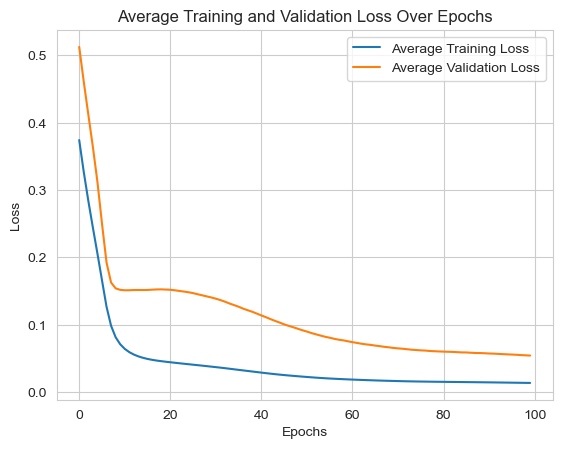

In [49]:
# Calculate average training and validation loss over all trials at each epoch
avg_train_loss = np.mean([trial_history.history['loss'] for trial_history in all_trial_histories], axis=0)
avg_val_loss = np.mean([trial_history.history['val_loss'] for trial_history in all_trial_histories], axis=0)

# Plot average training and validation loss
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Over Epochs')
plt.legend()
plt.show()